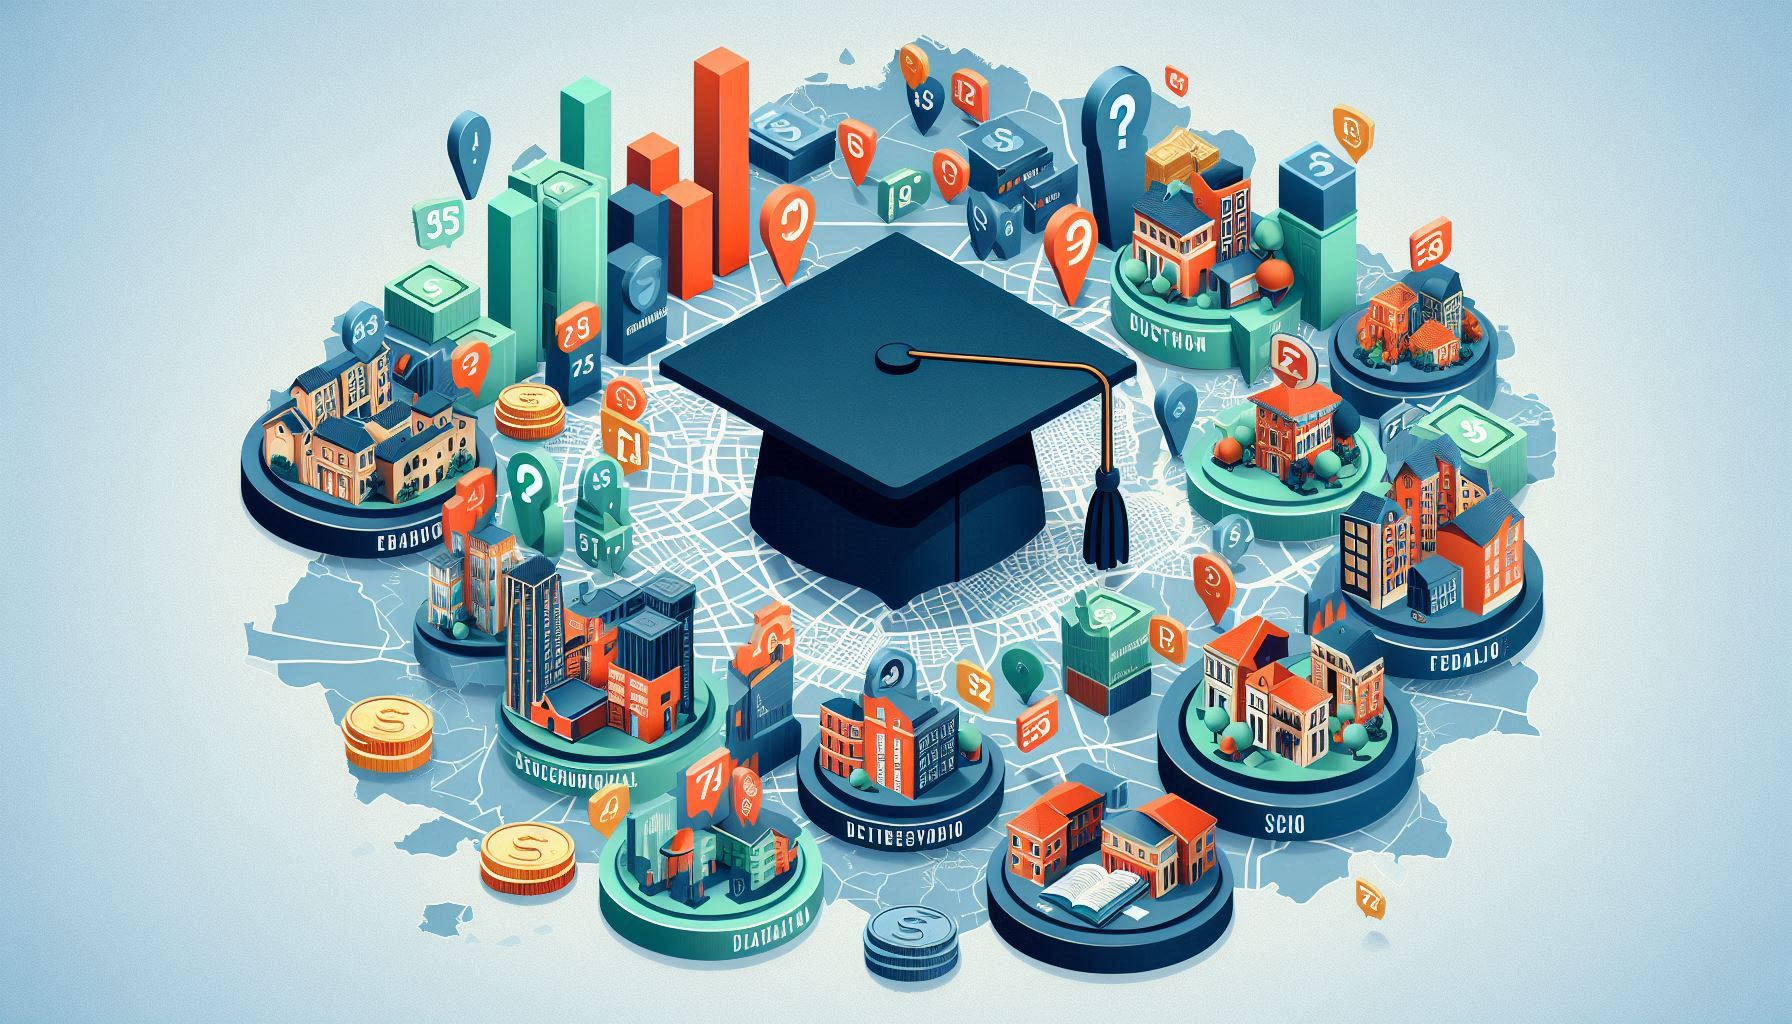

### TEMÁTICA

 --> **Educación**

### HIPÓTESIS

--> *¿Influye el nivel económico de las familias en la obtención de un nivel de estudios adecuado? Además, ¿depende del distrito en el que vivan?*

##### Importo librerías necesarias

In [44]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from scipy.stats import mannwhitneyu
import seaborn as sns

In [45]:
from src.utils.funciones import *
from src.utils.bootcampviztools import *

#### CARGO LOS DATOS PROCESADOS Y LIMPIOS

En primer lugar cargamos los datos del DataFrame que:

- Guarda todos los datos de los niveles de las etapas educativas, los diferentes distritos y los cursos educativos 2014-2015 y 2020-2021

- Guarda la renta anual de cada distrito y de los años 2014 y 2020

In [46]:
df_estudios = pd.read_json("./src/data/json/df_estudios.json", orient="records", lines=True)
df_renta = pd.read_json("./src/data/json/df_renta.json", orient="records", lines=True)


In [47]:
df_estudios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Niveles           420 non-null    object 
 1   Total             420 non-null    int64  
 2   Distrito          420 non-null    object 
 3   Curso_escolar     420 non-null    object 
 4   Tasa_idoneidad_%  420 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 16.5+ KB


##### 1.  TIPIFICACIÓN DE DATOS

Realizaremos una tificación de cada una de las variables de `df_estudios` a la hora de realizar los análisis

In [48]:
cardinalidad_estudios = cardinalidad(df_estudios, 22, 50)
cardinalidad_estudios

,Card,%_Card,Tipo,Clasificación_como
Niveles,10,2.380952,object,Categórica
Total,369,87.857143,int64,Numérica Continua
Distrito,21,5.000000,object,Categórica
Curso_escolar,2,0.476190,object,Binaria
Tasa_idoneidad_%,226,53.809524,float64,Numérica Continua


A continuación se realizará la tipificación de las variables de `df_renta`

In [49]:
cardinalidad_renta = cardinalidad(df_renta, 22, 30)
cardinalidad_renta

,Card,%_Card,Tipo,Clasificación_como
Año,2,4.761905,int64,Binaria
Distrito,21,50.000000,object,Categórica
Renta,42,100.000000,float64,Numérica Continua


##### 2.  CLASIFICACIÓN DE LAS VARIABLES

Tabla clasificatoria de `df_estudios`

|Columna/Variable|Descripción|Tipo_de_Variable|Importancia inicial|Nota|
|-|-|-|-|-|
|Niveles|Etapa educativa|Categórica|2|Primaria y ESO|
|Total|Total de alumnos matricualados|Numérica Continua|3|No se discrimina por sexos|
|Distrito|Distrito de Madrid al que pertenecen los datos|Categórica|1|Demográfica|
|Curso_escolar|Cursos de los años que representan los datos|Binaria|2|Académica|
|Tasa_idoneidad_%|Tasa de efectividad del nivel educativo|Numérica Continua|1|En porcentaje. El número reflejado corresponde a las personas que sí han superado ese nivel con respecto al total de matriculados|

Tabla clasificatoria de `df_renta`

|Columna/Variable|Descripción|Tipo_de_Variable|Importancia inicial|Nota|
|-|-|-|-|-|
|Año|Año en el que corresponde la renta anual dada|Binaria|2|Temporal|
|Distrito|Distrito de Madrid al que pertenecen los datos|Categórica|1|Demográfica|
|Renta|Renta media anual de los hogares|Numérica Continua|1|Demográfica|

In [50]:
# Clasifico en una variable, las variables categóricas y numéricas de 'df_estudios'
categoricas_estudios = []
for variable, valor in cardinalidad_estudios["Clasificación_como"].items():
    if valor == "Categórica" or valor == "Binaria":
        categoricas_estudios.append(variable)

categoricas_estudios


['Niveles', 'Distrito', 'Curso_escolar']

In [51]:
numericas_estudios = []
for variable, valor in cardinalidad_estudios["Clasificación_como"].items():
    if valor == "Numérica Continua":
        numericas_estudios.append(variable)

numericas_estudios

['Total', 'Tasa_idoneidad_%']

In [52]:
categoricas_renta = []
for variable, valor in cardinalidad_renta["Clasificación_como"].items():
    if valor == "Categórica" or valor == "Binaria":
        categoricas_renta.append(variable)

categoricas_renta

['Año', 'Distrito']

In [53]:
numericas_renta = []
for variable, valor in cardinalidad_renta["Clasificación_como"].items():
    if valor == "Numérica Continua":
        numericas_renta.append(variable)

numericas_renta

['Renta']

##### 3.  ANÁLISIS

**3.1. Análisis descriptivo de las variables numéricas del `df_estudios`**



In [54]:
# Análisis de 'Total'
df_estudios["Total"].describe()

count     420.000000
mean     1372.388095
std       592.244450
min       358.000000
25%       900.250000
50%      1295.500000
75%      1934.000000
max      3023.000000
Name: Total, dtype: float64

- *Se puede observar que los datos no están muy dispersos ya que la media y la mediana, en este caso el percentil 50, tiene cierto grado de similitud*
- *Además, también se aprecia que entre el máximo y el percentil 75 sí existe cierta distancia. ¿Se puede intuir que hay algún outlier?*

In [55]:
# Análisis de "Tasa_idoneidad_%"
df_estudios["Tasa_idoneidad_%"].describe()

count    420.000000
mean      86.862381
std       11.208023
min       52.300000
25%       80.875000
50%       89.850000
75%       95.300000
max      100.000000
Name: Tasa_idoneidad_%, dtype: float64

- *Teniendo una media de 86% de los alumnos que superan el nivel y con un percentil 50 (mediana) del 89%, se observa que los datos no están muy dispersos*
- *Además, entre el máximo (100%, queriendo decir que hay alguna etapa que es superada por todos los alumnos), y el percentil 75 (95%), hay muy poca diferencia*
- *También, podemos ver que el mínimo está en el 52,3%, por lo que hay una etapa educativa que han superado los estudios la mitad de los alumnos matriculados, dato curiosos que habrá que analizar*

**3.2. Análisis de las variables numéricas de `df_estudios`**

(2, 2)


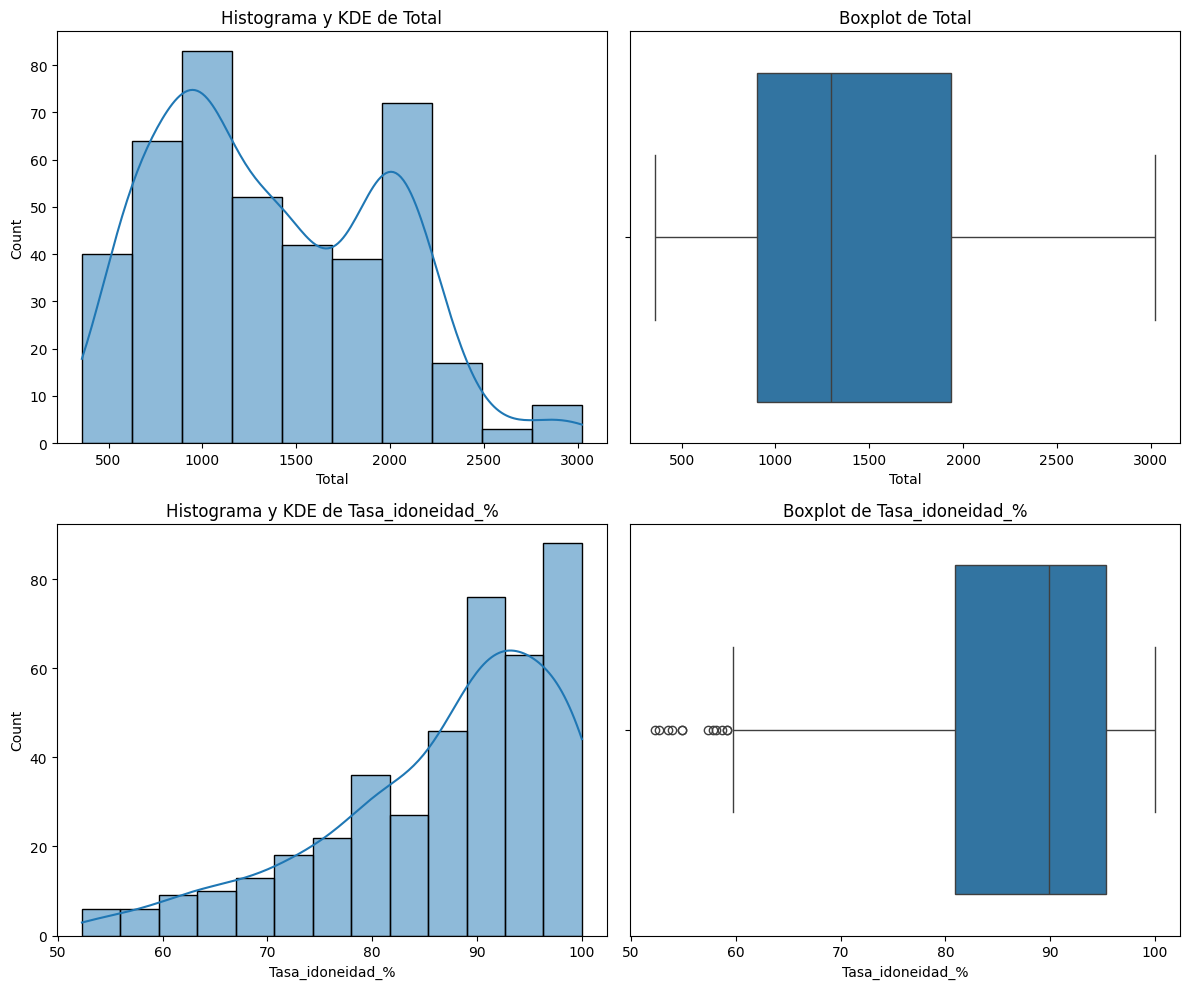

In [56]:
# Histograma con diagrama de cajas

plot_combined_graphs(df_estudios, numericas_estudios);

*En la variable `Total`*:
- *Con estos gráficos se verifica que no hay datos dispersos, concentrándose en el rango entre 900 y 2000. Además, aunque la longitud entre el máximo y el percentil 75 sea un poco alta, no se observan outliers*

*En la variable `Tasa_idoneidad_%`:*
- *Se observa, en el diagrama de cajas, que hay una serie de outlier por debajo del 60%, esto significa que hay en algún nivel que no supera los estudios la mitad del alumnado matriculado. Esto es una buena observación para preguntarnos si está relacionado con el nivel económico de las familias y el distrito*

**3.3. Análisis entre categóricas y numéricas**

Como las variables categóricas por sí solas no muestran unos resultados útiles, comenzaré a combinarlas entre las numéricas

> Primero quiero visualizar en una gráfica el número total de matriculados en cada nivel y dependiendo del curso escolar.

In [57]:
# Separo un DF únicamente con el curso 2014-2015 para ver el total de alumnos matriculados ese curso
df_estudios_2014 = df_estudios.loc[df_estudios["Curso_escolar"] == "2014-2015"]
df_estudios_2020 = df_estudios.loc[df_estudios["Curso_escolar"] == "2020-2021"]

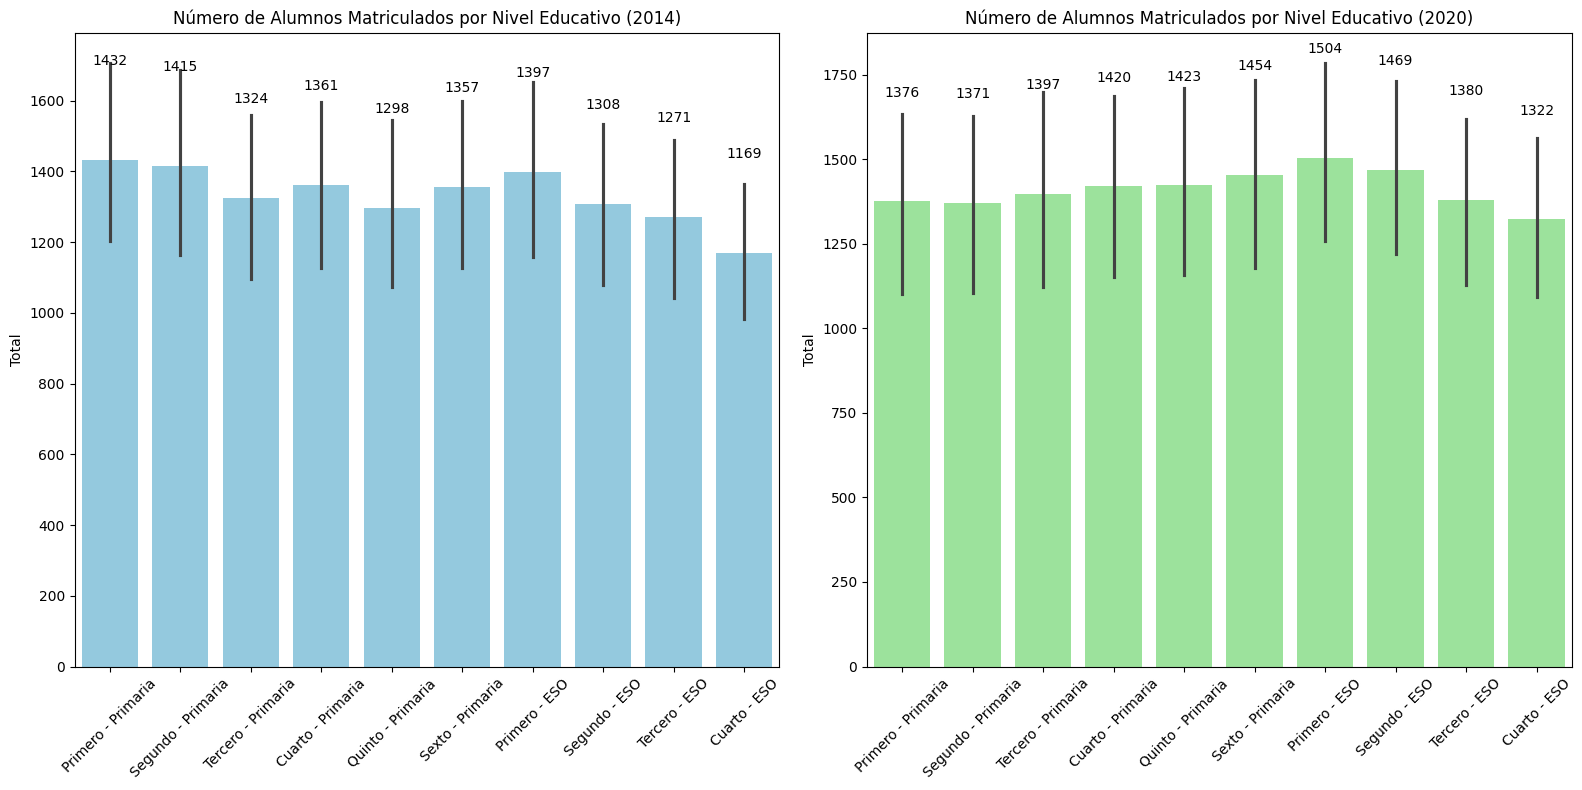

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Grafica de los datos de 2014
sns.barplot(x="Niveles", y="Total", data=df_estudios_2014, color="skyblue", ax=axs[0])
axs[0].set_title("Número de Alumnos Matriculados por Nivel Educativo (2014)")
axs[0].set_xlabel('')  # Quitar etiqueta del eje x
axs[0].tick_params(axis="x", rotation=45)  # Ocultar ticks y etiquetas del eje x

# Mostrar lo valores
for p in axs[0].patches:
    height = p.get_height()
    axs[0].annotate(f'{height:.0f}',
                    (p.get_x() + p.get_width() / 2, height + 260), 
                    ha="center", va="bottom", fontsize=10, color="black")

# Grafica de los datos de 2020
sns.barplot(x="Niveles", y='Total', data=df_estudios_2020, color='lightgreen', ax=axs[1])
axs[1].set_title('Número de Alumnos Matriculados por Nivel Educativo (2020)')
axs[1].set_xlabel('')  
axs[1].tick_params(axis='x', rotation=45) 


for p in axs[1].patches:
    height = p.get_height()
    axs[1].annotate(f'{height:.0f}',
                    (p.get_x() + p.get_width() / 2, height + 300), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout() 
plt.show()

*No se muestra nada significativo entre las dos gráficas, únicamente que respecto a un año y a otro hay una bajada en la primera etapa (PRIMARIA) y una subida consierable en la segunda etapa (ESO). ¿Puede ser por la pandemia? Entraría en juego otras variables como el número de nacimientos. **Por lo tanto, descarto esta gráfica para mi hipótesis***


> A continuación visuaizaremos el número de matriculados por distrito según el curso escolar.

Como hay 21 distritos, sería complicado visualizarlos todos en una gráfica o en varias para poder analizarlo, por lo que realizaremos un top 7 de más alumnos matriculados en total y un top 7 de menos matriculados.

In [59]:
top_distrito_mas = df_estudios.groupby("Distrito")["Total"].sum().nlargest(7).index #Buscamos los 7 distritos con más alumnos matriculados
top_distrito_mas

Index(['Fuencarral-El Pardo', 'Puente de Vallecas', 'Hortaleza', 'Chamartín',
       'Latina', 'Carabanchel', 'Ciudad Lineal'],
      dtype='object', name='Distrito')

In [60]:

df_top_7_mas = df_estudios[df_estudios["Distrito"].isin(top_distrito_mas)]  # Lo busco en mi DF principal para tener los datos

df_top_7_mas

,Niveles,Total,Distrito,Curso_escolar,Tasa_idoneidad_%
24,Primero - Primaria,2104,Carabanchel,2014-2015,100.0
25,Segundo - Primaria,2153,Carabanchel,2014-2015,98.9
26,Tercero - Primaria,1975,Carabanchel,2014-2015,91.3
27,Cuarto - Primaria,1974,Carabanchel,2014-2015,89.9
28,Quinto - Primaria,1887,Carabanchel,2014-2015,83.3
...,...,...,...,...,...
351,Cuarto - ESO,1867,Puente de Vallecas,2014-2015,54.9
352,Primero - ESO,2334,Puente de Vallecas,2020-2021,69.2
353,Segundo - ESO,2338,Puente de Vallecas,2020-2021,67.5
354,Tercero - ESO,2024,Puente de Vallecas,2020-2021,62.5


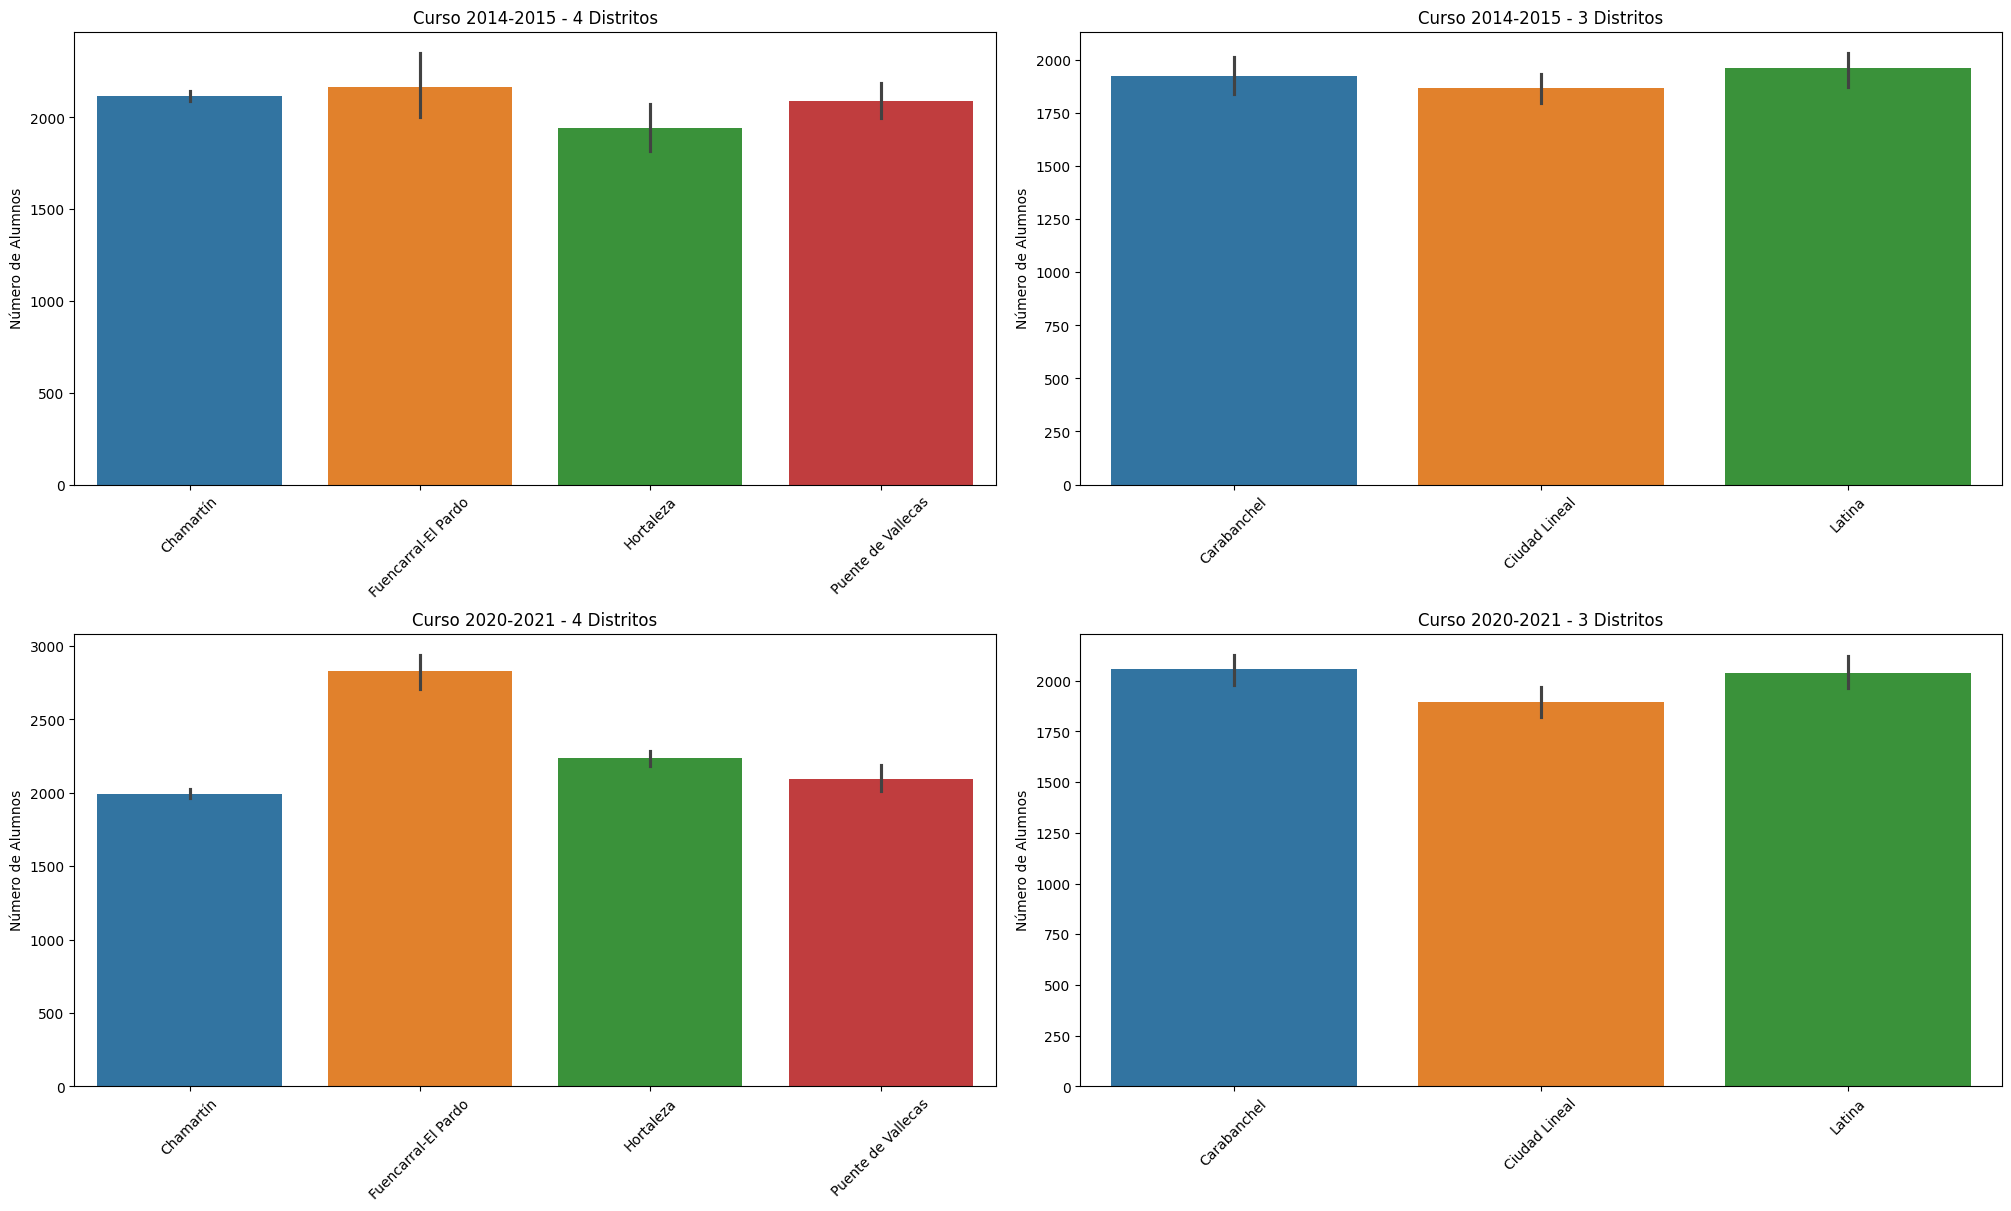

In [61]:
# Defino los cursos y  los distritos para los subplots
cursos = ["2014-2015", "2020-2021"]
distritos = list(top_distrito_mas)
top_distritos_4 = distritos[:4]
top_distritos_3 = distritos[4:]

fig, axs = plt.subplots(2, 2, figsize=(20, 12), constrained_layout=True)

# Configurar cada subplot
for i, curso in enumerate(cursos):
    df_curso = df_top_7_mas[df_top_7_mas["Curso_escolar"] == curso]
    
    # Primer grupo de 4 distritos
    sns.barplot(
        data=df_curso[df_curso["Distrito"].isin(top_distritos_4)],
        x="Distrito",
        y="Total",
        ax=axs[i, 0],
        hue = "Distrito"
    )
    axs[i, 0].set_title(f"Curso {curso} - 4 Distritos")
    axs[i, 0].set_xlabel("")
    axs[i, 0].set_ylabel("Número de Alumnos")
    axs[i, 0].tick_params(axis="x", rotation=45)

    
    # Segundo grupo de 3 distritos
    sns.barplot(
        data=df_curso[df_curso["Distrito"].isin(top_distritos_3)],
        x="Distrito",
        y="Total",
        ax=axs[i, 1],
        hue="Distrito"
    )
    axs[i, 1].set_title(f"Curso {curso} - 3 Distritos")
    axs[i, 1].set_xlabel("")
    axs[i, 1].set_ylabel("Número de Alumnos")
    axs[i, 1].tick_params(axis='x', rotation=45)

plt.show()

*Fuencarral-el Pardo, en los dos cursos es el distrito con más alumnos en los dos cursos, pero... ¿y qué distrito es el que menos alumnos matriculados tiene por cada curso?*

> Realizamos las mismas gráficas pero con los 7 distritos con menos alumnos tiene

In [62]:
top_distrito_menos = df_estudios.groupby("Distrito")["Total"].sum().nsmallest(7).index #Buscamos los 7 distritos con menos alumnos matriculados
top_distrito_menos

Index(['Barajas', 'Tetuán', 'Vicálvaro', 'Centro', 'Moratalaz', 'Arganzuela',
       'Retiro'],
      dtype='object', name='Distrito')

In [63]:
df_top_7_menos = df_estudios[df_estudios["Distrito"].isin(top_distrito_menos)]  # Lo busco en mi DF principal para tener los datos

df_top_7_menos

,Niveles,Total,Distrito,Curso_escolar,Tasa_idoneidad_%
0,Primero - Primaria,1061,Arganzuela,2014-2015,100.0
1,Segundo - Primaria,1020,Arganzuela,2014-2015,99.1
2,Tercero - Primaria,971,Arganzuela,2014-2015,95.3
3,Cuarto - Primaria,940,Arganzuela,2014-2015,94.9
4,Quinto - Primaria,883,Arganzuela,2014-2015,91.3
...,...,...,...,...,...
399,Cuarto - ESO,520,Vicálvaro,2014-2015,64.9
400,Primero - ESO,809,Vicálvaro,2020-2021,79.5
401,Segundo - ESO,807,Vicálvaro,2020-2021,81.5
402,Tercero - ESO,692,Vicálvaro,2020-2021,77.6


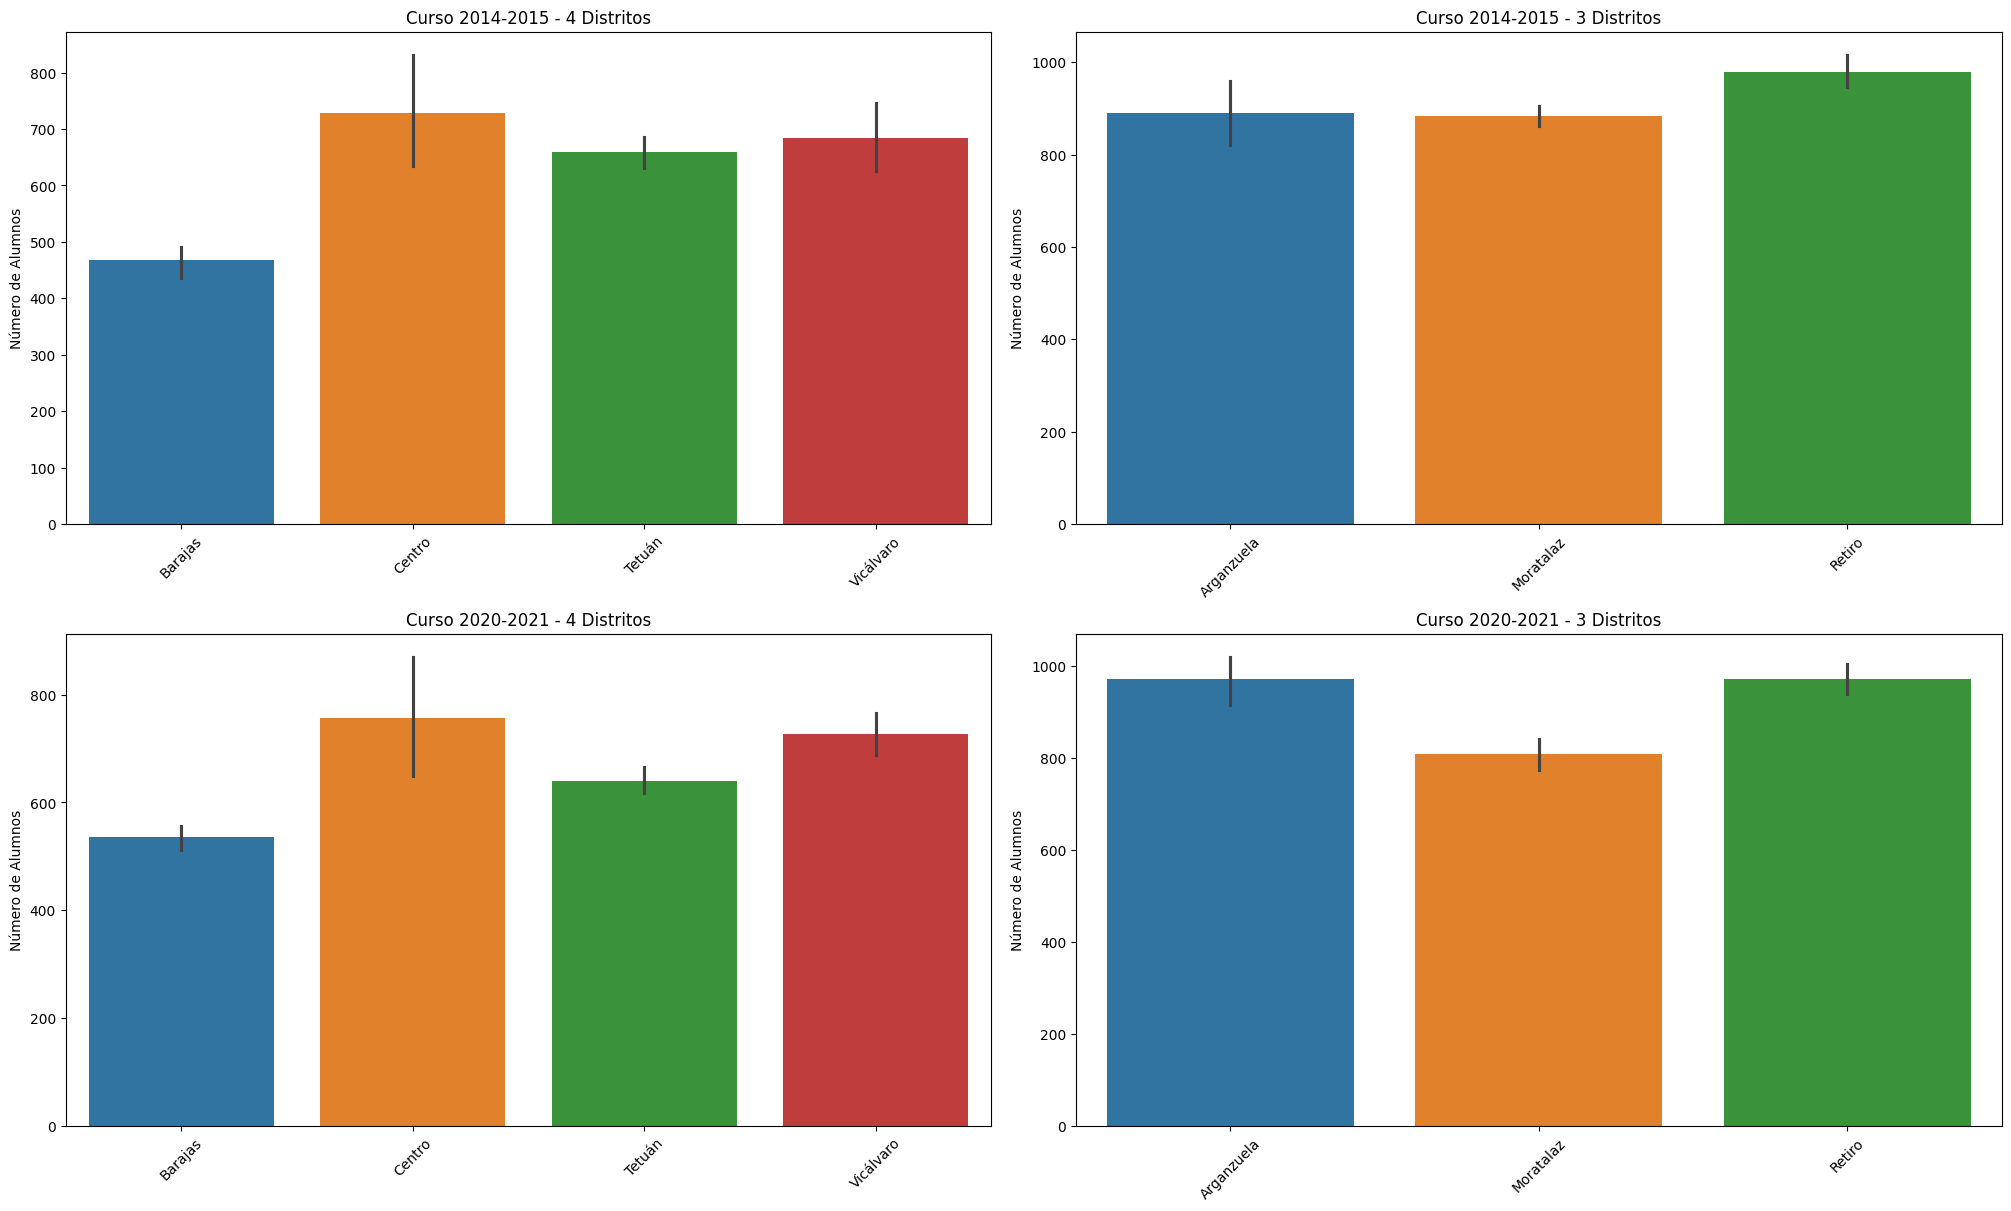

In [64]:
cursos = ["2014-2015", "2020-2021"]
distritos = list(top_distrito_menos)
distritos_4 = distritos[:4]
distritos_3 = distritos[4:]

fig, axs = plt.subplots(2, 2, figsize=(20, 12), constrained_layout=True)

for i, curso in enumerate(cursos):
    df_curso = df_top_7_menos[df_top_7_menos["Curso_escolar"] == curso]
    
    # Primer grupo de 4 distritos
    sns.barplot(
        data=df_curso[df_curso["Distrito"].isin(distritos_4)],
        x="Distrito",
        y="Total",
        ax=axs[i, 0],
        hue = "Distrito"
    )
    axs[i, 0].set_title(f"Curso {curso} - 4 Distritos")
    axs[i, 0].set_xlabel("")
    axs[i, 0].set_ylabel("Número de Alumnos")
    axs[i, 0].tick_params(axis="x", rotation=45)
    
    # Segundo grupo de 3 distritos
    sns.barplot(
        data=df_curso[df_curso["Distrito"].isin(distritos_3)],
        x="Distrito",
        y="Total",
        ax=axs[i, 1],
        hue="Distrito"
    )
    axs[i, 1].set_title(f"Curso {curso} - 3 Distritos")
    axs[i, 1].set_xlabel("")
    axs[i, 1].set_ylabel("Número de Alumnos")
    axs[i, 1].tick_params(axis="x", rotation=45)


plt.show()

*El distrito que menos alumnos tiene por cada curso es el de Barajas. Estos datos pueden indicar que en estas zonas, tanto el distrito que más alumnos se ha matriculado como el que menos, seguramente dependa de la densidad de población. Por lo que este indicador no nos interesa demasiado.**Por lo que estas gráficas, tanto el de más alumnos como el que menos, no nos influye a la hora de analizar nuestra hipótesis***

> Ahora analizaremos la tasa de idoneidad por cada nivel educativo y por cada año. Por lo que realizaremos un análisis multivariante entre dos categóricas.

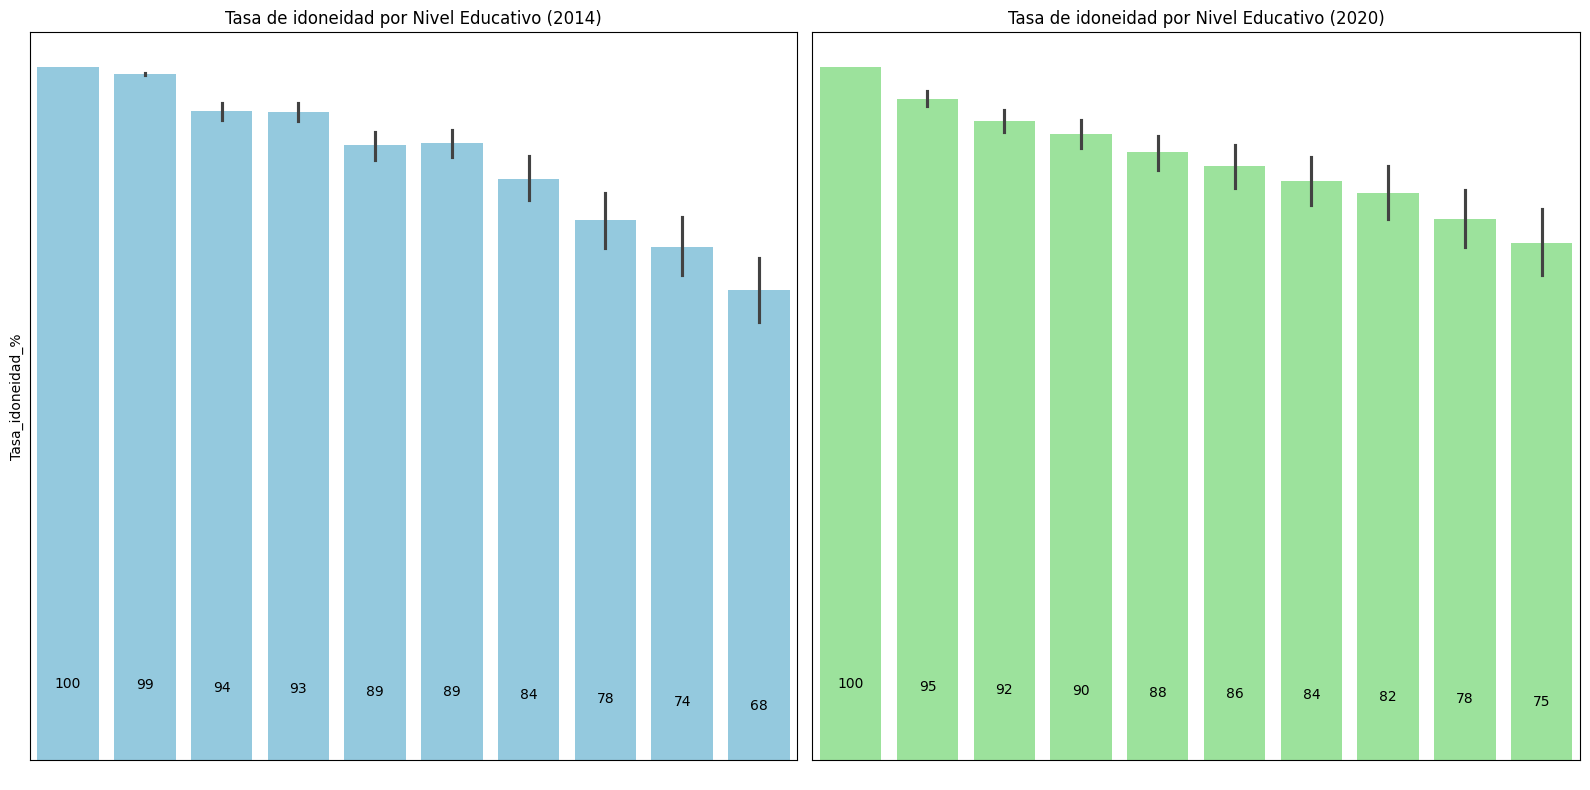

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Grafica de los datos de 2014
sns.barplot(x="Niveles", y="Tasa_idoneidad_%", data=df_estudios_2014, color="skyblue", ax=axs[0])
axs[0].set_title("Tasa de idoneidad por Nivel Educativo (2014)")
axs[0].set_xlabel(" ")  # Quitar etiqueta del eje x
axs[0].tick_params(axis="x", bottom=False, labelbottom=False)  # Ocultar ticks y etiquetas del eje x
axs[0].tick_params(axis="y", left=False, labelleft=False)

# Mostrar lo valores
for p in axs[0].patches:
    height = p.get_height()
    axs[0].annotate(f'{height:.0f}',
                    (p.get_x() + p.get_width() / 2, height * 0.1), ha="center", va="bottom", fontsize=10, color="black")

# Grafica de los datos de 2020
sns.barplot(x="Niveles", y="Tasa_idoneidad_%", data=df_estudios_2020, color='lightgreen', ax=axs[1])
axs[1].set_title("Tasa de idoneidad por Nivel Educativo (2020)")
axs[1].set_xlabel("")  
axs[1].set_ylabel("")
axs[1].tick_params(axis="x", bottom=False, labelbottom=False) 
axs[1].tick_params(axis="y", left=False, labelleft=False)


for p in axs[1].patches:
    height = p.get_height()
    axs[1].annotate(f'{height:.0f}',
                    (p.get_x() + p.get_width() / 2, height * 0.1), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout() 
plt.show()

*Se observa que según se avanza en los nivles educativos, por norma general, va disminuyendo esa tasa de idoneidad, es decir, va aumentando la cantidad de alumnos que repite en cada etapa. Esto puede deberse, entre otras cosas, por la dificultad que conlleva cada nivel. A más nivel, más dificultad.*

*Esto es un análisis por niveles, pero...¿influirá la renta de las familias?*

> Realizaremos un análisis descriptivo de la `renta` de `df_renta`

In [66]:
df_renta.Renta.describe()

count       42.000000
mean     42111.670260
std      13371.775379
min      23405.032090
25%      30933.349666
50%      38235.740296
75%      54281.608428
max      69915.639942
Name: Renta, dtype: float64

*Aquí observamos las rentas de manera conjunta, aunando los dos años. Observamos que la media (42111.67) y el percentil 50 (38236.74) hay una ligera dispersión. Y entre el máximo (69915.63) y el percentil 75 (54281.60) hay más diferencia que el anterior por lo que puede haber una dispersión en los datos*

> Para poder ver mejor si hay una dispersión en los datos, veremos visualmente como se concentran.

(2,)


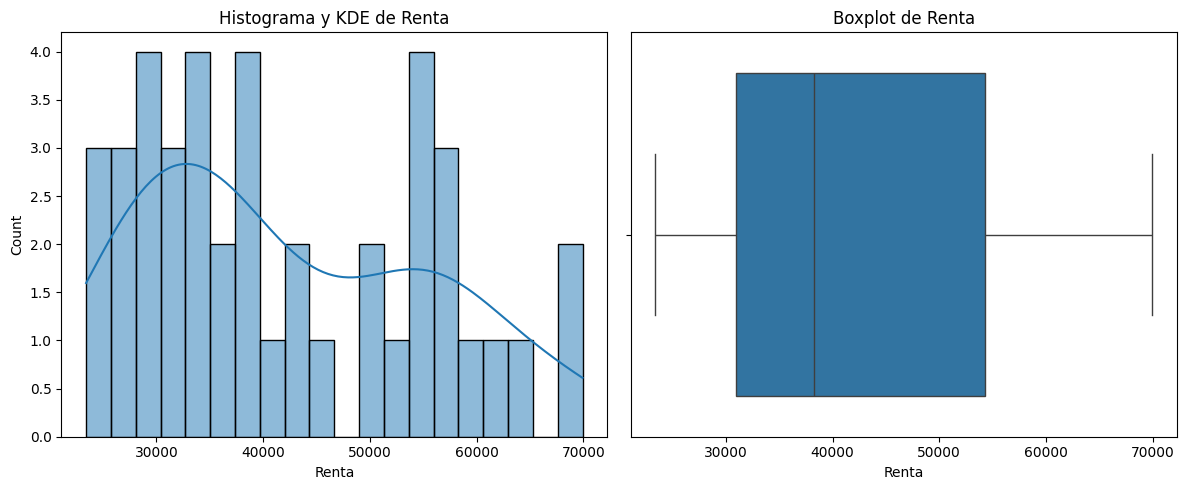

In [67]:
plot_combined_graphs(df_renta, ["Renta"], bins=20);

- *Gracias a estas gráficas, podemos ver que hay diferentes picos de concentración, uno entre 20k y 40k, otro grupo entre los 50k y 60k y uno pequeño superando los 65k.*

- *Con el Boxplot, no hay outliers por lo que no hay ningún dato que destaque ni por ser muy alto ni muy bajo*.

- *En definitiva, lo datos están concentrados en diferentes puntos de la gráfica pero su dispersión no es muy notable.*

> Ahora lo veremos mucho mejor diferenciando por cada año

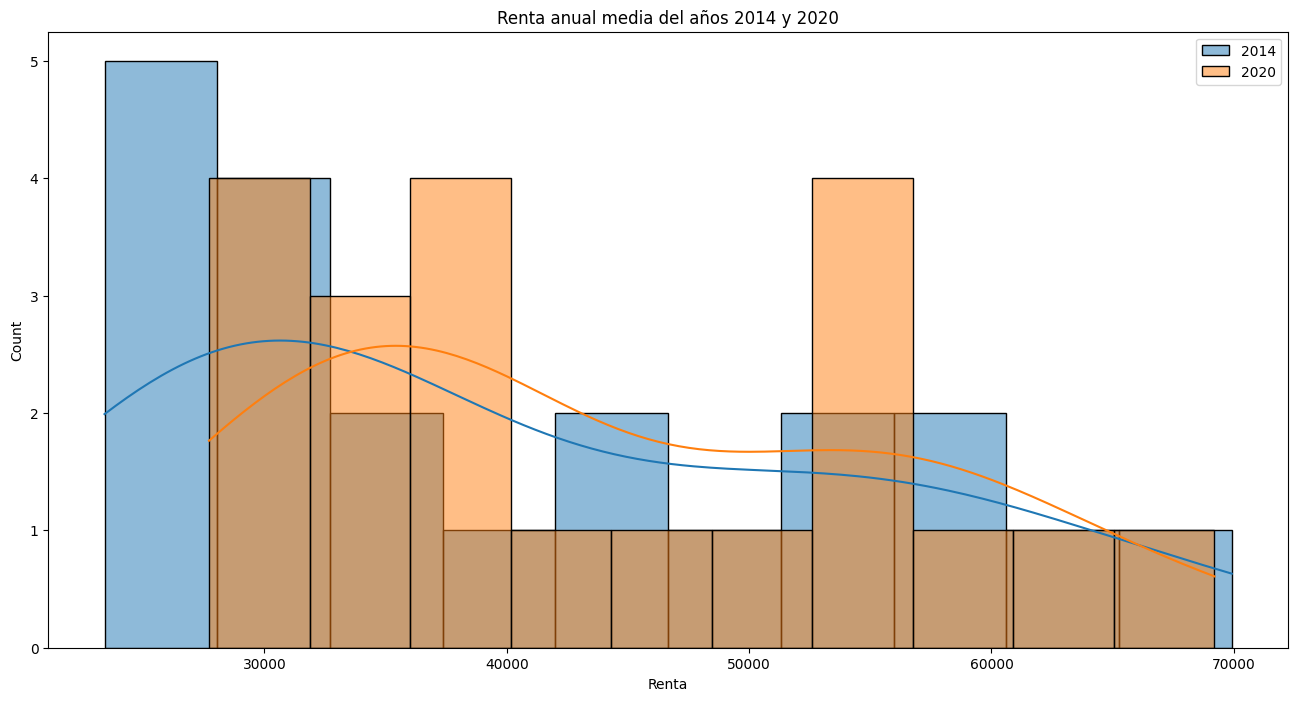

In [68]:
plt.figure(figsize=(16,8))

# Grafica de la renta del 2014
for valor in df_renta["Año"].unique():
    sns.histplot(df_renta.loc[df_renta["Año"] == valor, "Renta"], kde=True, bins=10, label=valor)
plt.legend()
plt.title("Renta anual media del años 2014 y 2020")
plt.xlabel("Renta")

plt.show()

*Se pueden observar datos muy interesantes*:

- *En el año 2014, comenzaban teniendo una renta más baja que en el 2020* 

- *Se ve un incremento de salarios entre 30k y 40k entre ambos años, quedándose estable entre los 40k y 50k*

- *En 2020 hay un pico muy significativo entre los 50k y 60k con respecto al 2014*

- *En general, con lo que muestra esta gráfica ha habido un enriquecimiento desde el 2014 al 2020*

*¿Se mostrará parecido diferenciando por distritos?*

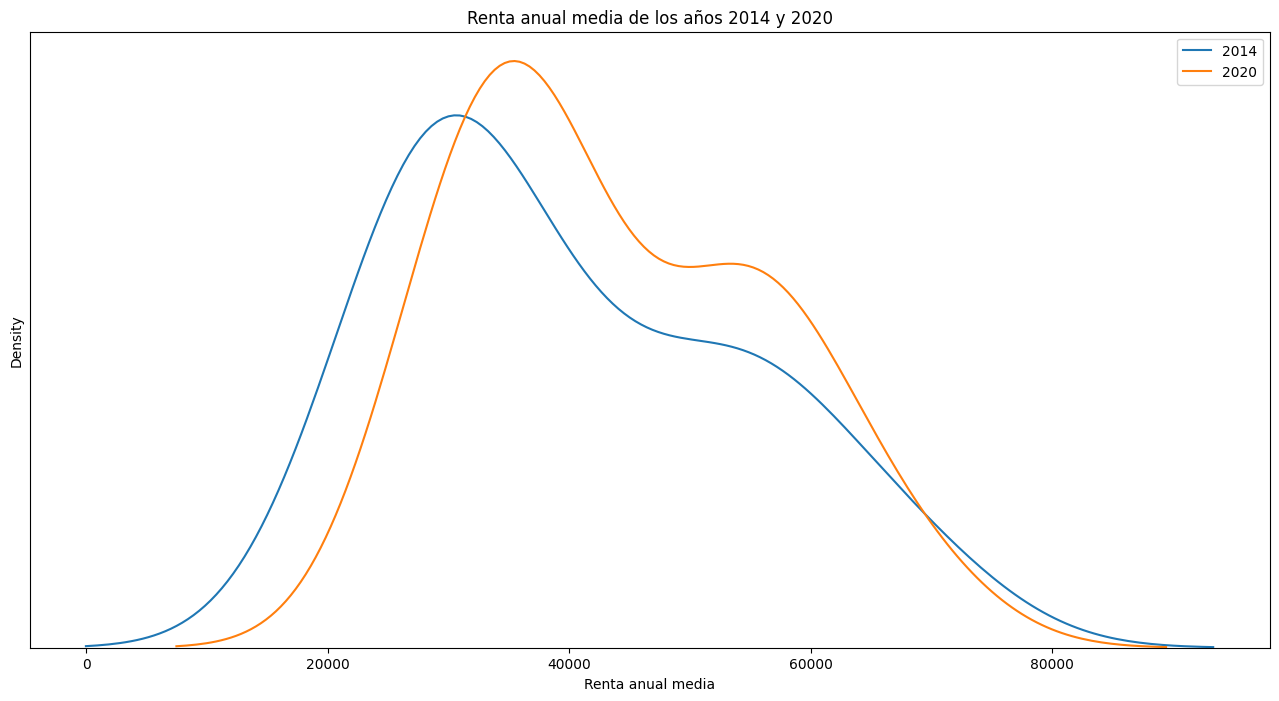

In [69]:
# Para mostrar en la presentación


plt.figure(figsize=(16,8))

for valor in df_renta["Año"].unique():
    sns.kdeplot(df_renta.loc[df_renta["Año"] == valor, "Renta"], label=valor)
plt.legend()
plt.title("Renta anual media de los años 2014 y 2020")
plt.xlabel("Renta anual media")
plt.yticks([])

plt.show()

> Una vez analizadas nuestras dos variables directoras (`tasa_idoneidad_%` y `Renta`), vamos a crear una gráfica de dispersión relacionándolas entre sí dependiendo del nivel educativo

In [70]:
df_estudios_copy = df_estudios.copy()

# Para poder unir los dos DF, hago una copia de seguridad y modifico el valor de los datos del curso escolar.
df_estudios_copy["Año"] = df_estudios_copy["Curso_escolar"].apply(lambda x: int(x.split("-")[0]))

df_estudios_copy.head()

,Niveles,Total,Distrito,Curso_escolar,Tasa_idoneidad_%,Año
0,Primero - Primaria,1061,Arganzuela,2014-2015,100.0,2014
1,Segundo - Primaria,1020,Arganzuela,2014-2015,99.1,2014
2,Tercero - Primaria,971,Arganzuela,2014-2015,95.3,2014
3,Cuarto - Primaria,940,Arganzuela,2014-2015,94.9,2014
4,Quinto - Primaria,883,Arganzuela,2014-2015,91.3,2014


In [71]:
df_union = df_estudios_copy.merge(df_renta, on=["Distrito", "Año"]) # Los uno con la columna 'Distrito' y 'Año'

df_union.head()

,Niveles,Total,Distrito,Curso_escolar,Tasa_idoneidad_%,Año,Renta
0,Primero - Primaria,1061,Arganzuela,2014-2015,100.0,2014,38308.480591
1,Segundo - Primaria,1020,Arganzuela,2014-2015,99.1,2014,38308.480591
2,Tercero - Primaria,971,Arganzuela,2014-2015,95.3,2014,38308.480591
3,Cuarto - Primaria,940,Arganzuela,2014-2015,94.9,2014,38308.480591
4,Quinto - Primaria,883,Arganzuela,2014-2015,91.3,2014,38308.480591


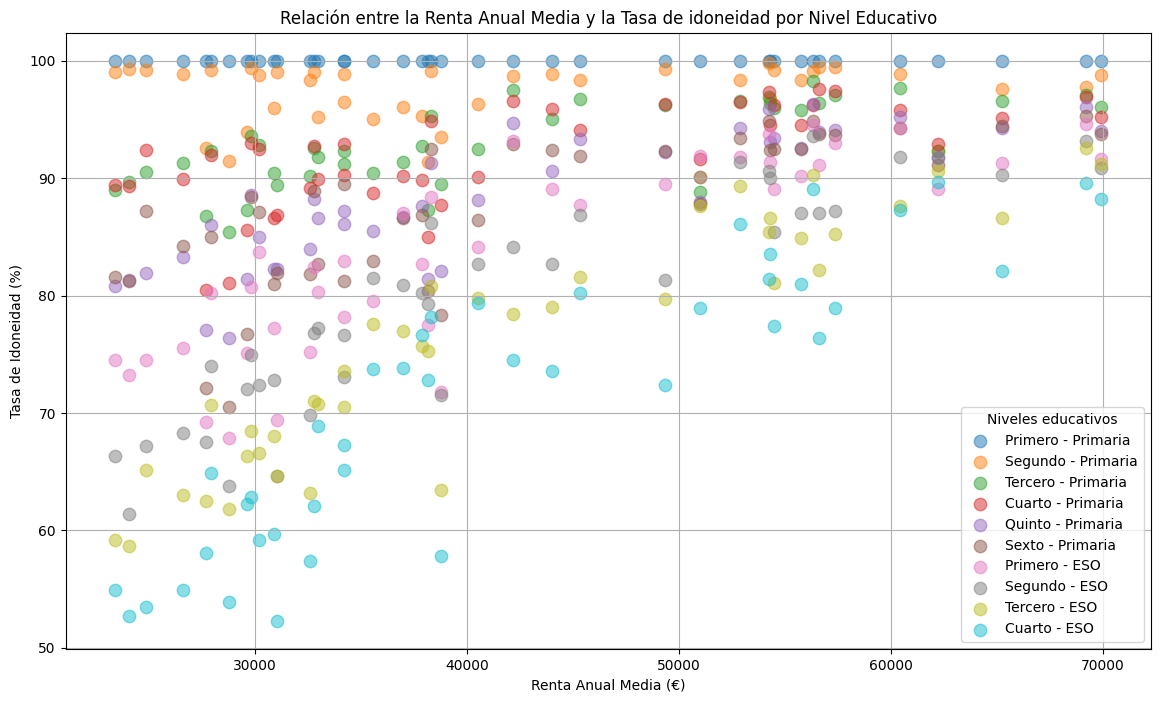

In [72]:
# Gráfico de dispersión por Nivel educativo
plt.figure(figsize=(14,8))
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

niveles = df_union["Niveles"].unique()
for i, nivel in enumerate(niveles):
    df_nivel = df_union[df_union["Niveles"] == nivel]
    plt.scatter(df_nivel["Renta"], df_nivel["Tasa_idoneidad_%"], label=nivel, color=colores[i], s=80, alpha=0.5)

plt.title("Relación entre la Renta Anual Media y la Tasa de idoneidad por Nivel Educativo")
plt.xlabel("Renta Anual Media (€)")
plt.ylabel("Tasa de Idoneidad (%)")
plt.legend(title="Niveles educativos")
plt.grid(True)
plt.show()

*Se puede observar perfectamente que las rentas de más de 40k comienzan a tener una tasa de idoneidad alta independientemente del curso, siempre siendo el último curso el más dificil. La forma de relación que tiene los puntos se puede decir que hay una correlación poitiva, es decir, según va aumentando la renta, aumenta la tasa de idoneidad. ¿Cómo será por año?*

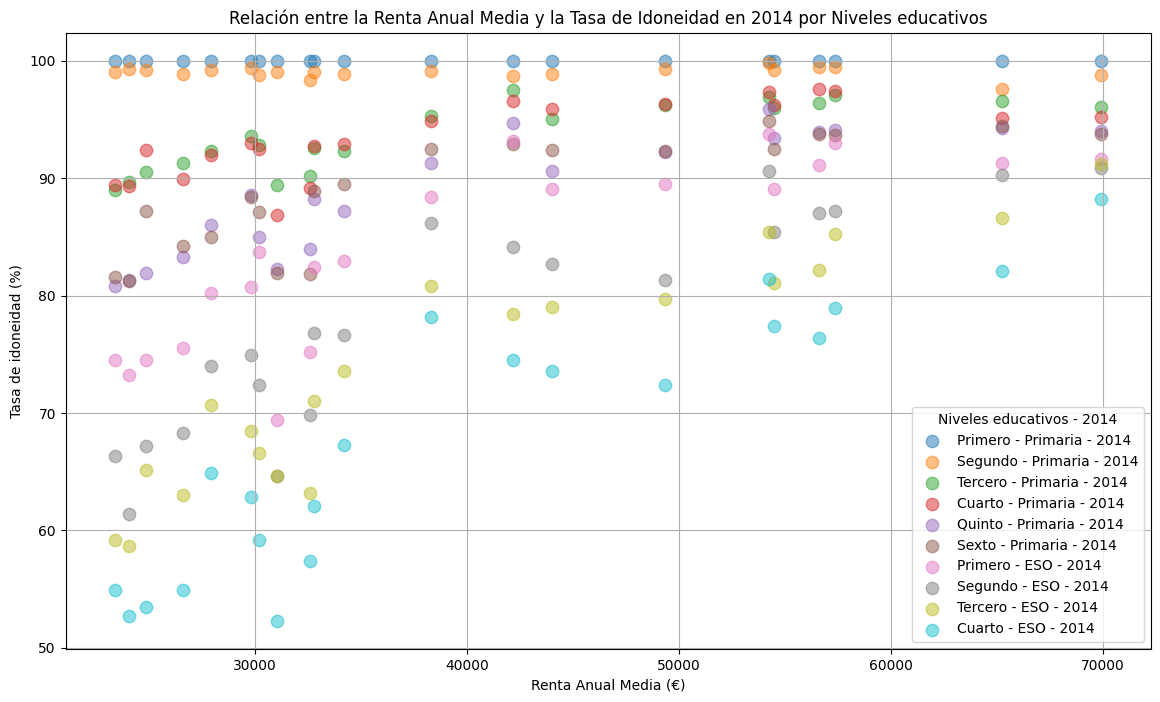

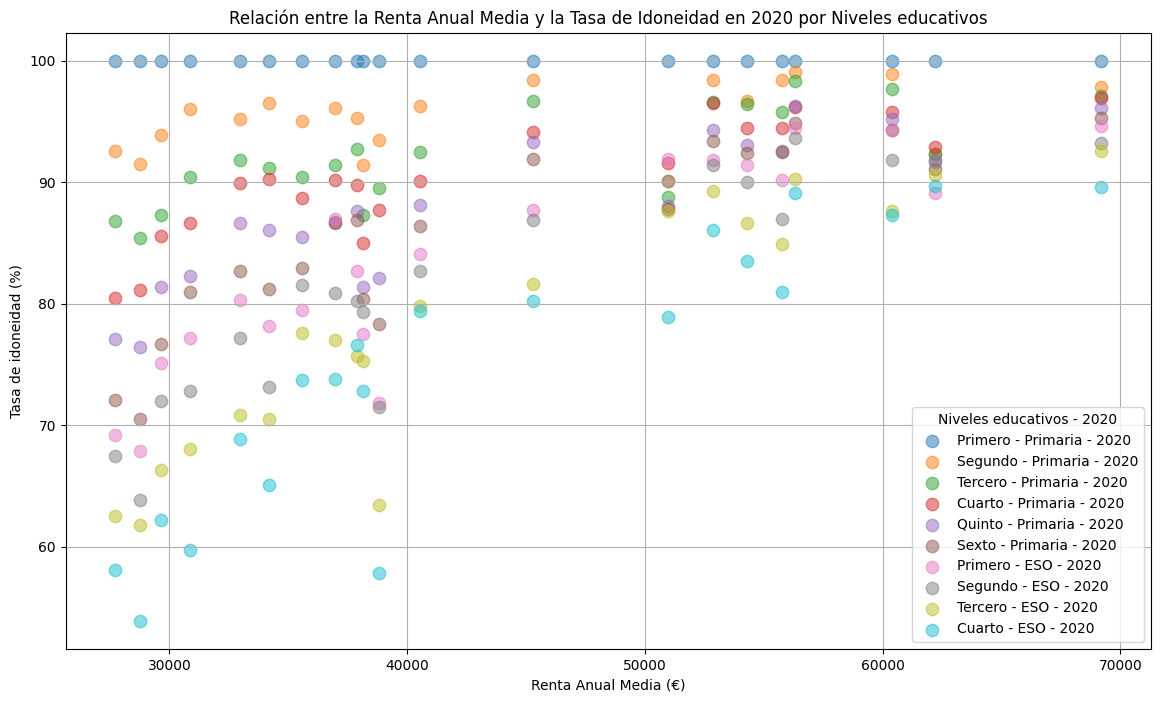

In [73]:
# Filtro por año
df_2014 = df_union[df_union["Año"] == 2014]
df_2020 = df_union[df_union["Año"] == 2020]

# Gráfico para visualizar el año 2014
plt.figure(figsize=(14,8))
for i, nivel in enumerate(niveles):
    df_nivel = df_2014[df_2014["Niveles"] == nivel]

    plt.scatter(df_nivel["Renta"], df_nivel["Tasa_idoneidad_%"], label=f"{nivel} - 2014", color=colores[i], s=80, alpha=0.5)

plt.title("Relación entre la Renta Anual Media y la Tasa de Idoneidad en 2014 por Niveles educativos")
plt.xlabel("Renta Anual Media (€)")
plt.ylabel("Tasa de idoneidad (%)")
plt.legend(title="Niveles educativos - 2014")
plt.grid(True)


plt.figure(figsize=(14,8))
for i, nivel in enumerate(niveles):
    df_nivel = df_2020[df_2020["Niveles"] == nivel]

    plt.scatter(df_nivel["Renta"], df_nivel["Tasa_idoneidad_%"], label=f"{nivel} - 2020", s=80, alpha=0.5)

plt.title("Relación entre la Renta Anual Media y la Tasa de Idoneidad en 2020 por Niveles educativos")
plt.xlabel("Renta Anual Media (€)")
plt.ylabel("Tasa de idoneidad (%)")
plt.legend(title="Niveles educativos - 2020")
plt.grid(True)
plt.show()


*Anteriormente observamos cómo ha avanzado y ha aumentado la renta media anual de las familias entre el 2014 y 2020, aquí también se ve reflejado por cada año. Ese aumento de la renta ha causado que l tasa de idoneidad aumente más rápido*

*En 2014, aumentaba ligeramente a partir de los 35k, y en el 2020 se aprecia perfectamente un corte y empieza a subir la tasa de idoneidad más rápido*

*Y, ¿cómo será esta distribución con los distritos?*

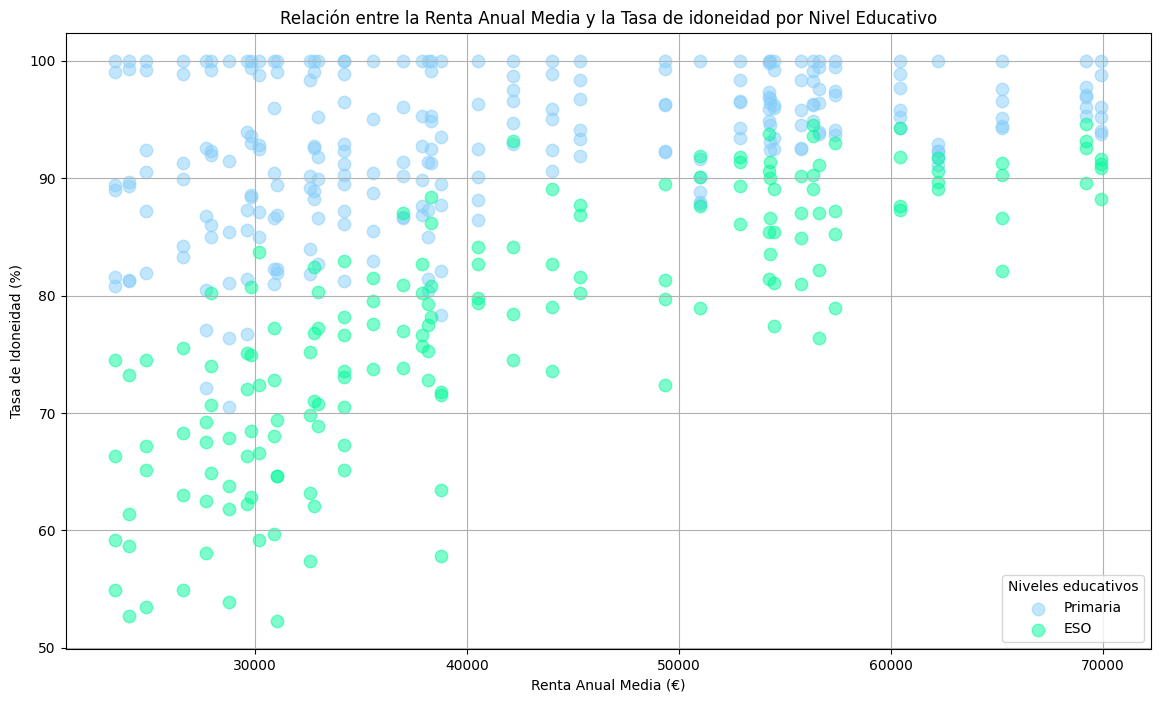

In [74]:
# Para la presentación voy a categorizar los niveles en Primaria y ESO para que no haya tanta distorisión en los puntos y se aprecie mejor para poder ser más comprensible
df_union["Categoria_Nivel"] = df_union['Niveles'].apply(categorizar_nivel) 

colores = ["lightskyblue", "mediumspringgreen"]

plt.figure(figsize=(14,8))

niveles = df_union["Categoria_Nivel"].unique()
for i, nivel in enumerate(niveles):
    df_nivel = df_union[df_union["Categoria_Nivel"] == nivel]
    plt.scatter(df_nivel["Renta"], df_nivel["Tasa_idoneidad_%"], label=nivel, color=colores[i], s=80, alpha=0.5)

plt.title("Relación entre la Renta Anual Media y la Tasa de idoneidad por Nivel Educativo")
plt.xlabel("Renta Anual Media (€)")
plt.ylabel("Tasa de Idoneidad (%)")
plt.legend(title="Niveles educativos")
plt.grid(True)
plt.show()


> Analizamos en un primer lugar la renta media anual y los distritos.

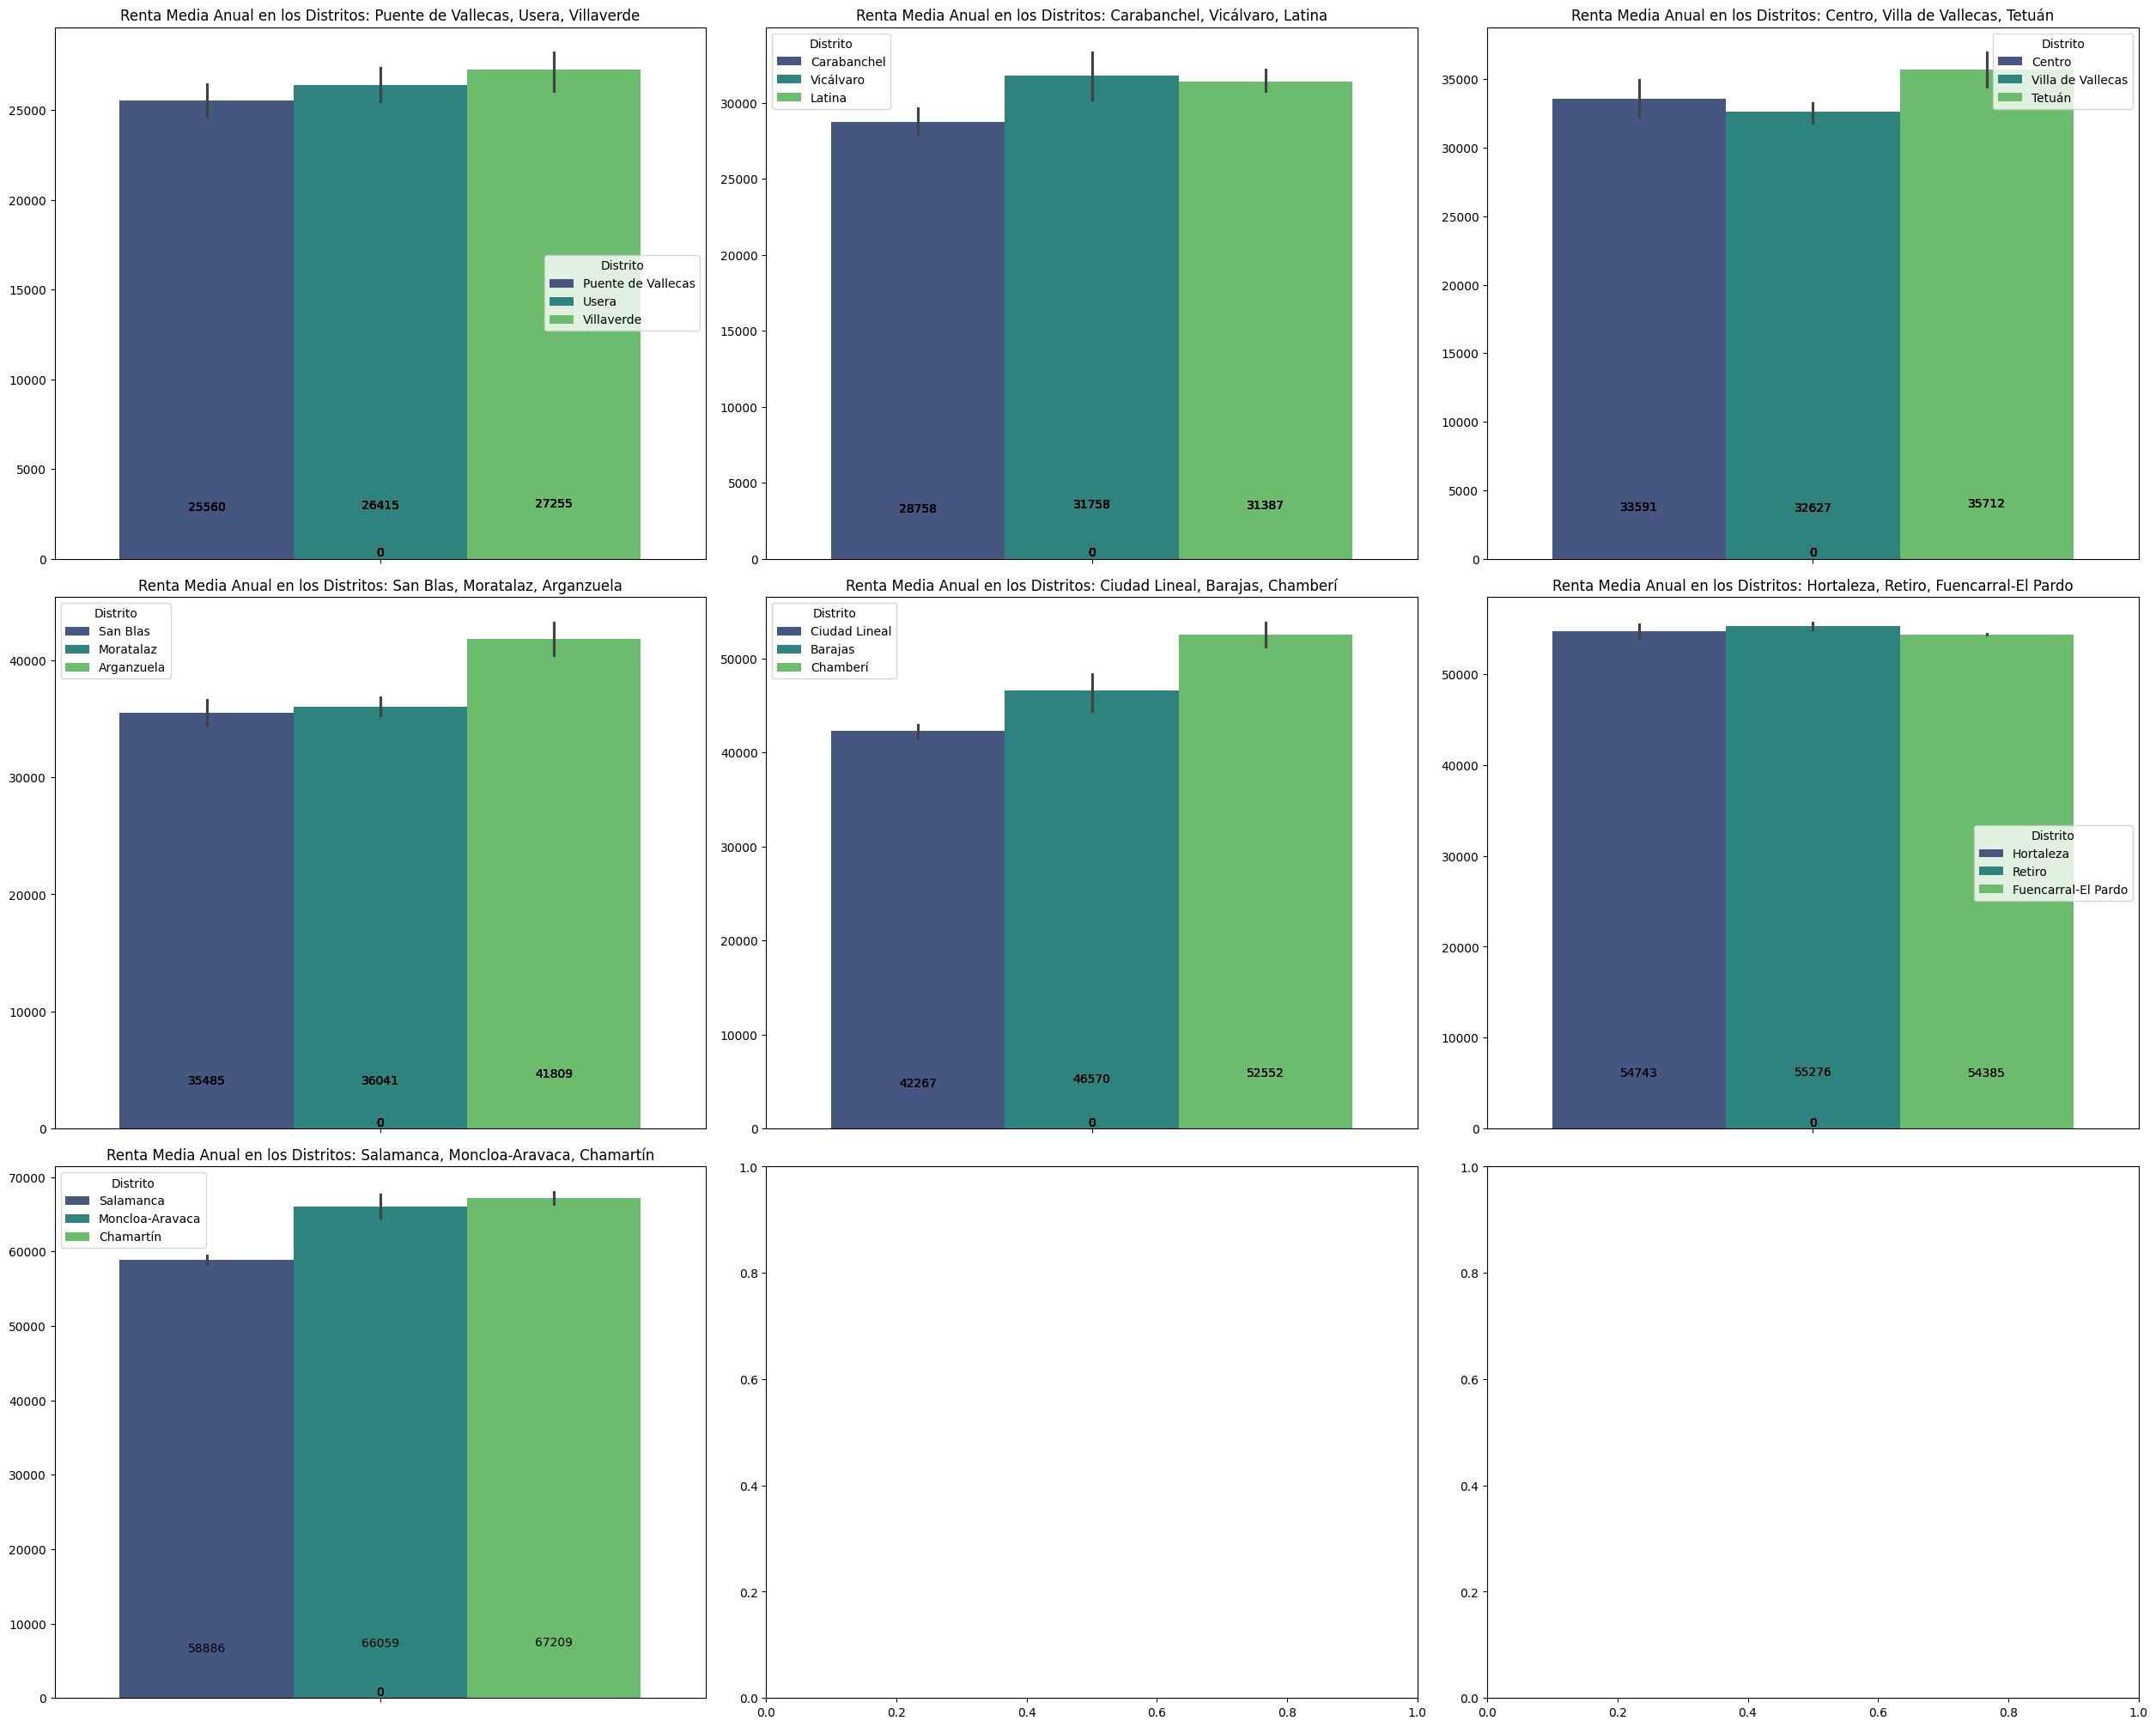

In [75]:
# Análisis bivariante entre una categórica y una numérica pero como la categórica es grande, para poder visualizarlo correctamente se dividirá en grupo de 3
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(25, 20), constrained_layout=True)

#  Filtrado
df_sort = df_union.sort_values(by="Renta") # Hago un sort values para que primero aparezcan los distritos más "pobres" y sea más fácil visualizarlo, así como a los más "ricos"
distritos = df_sort["Distrito"].unique() # Ceo una lista de los distritos que hay con el orden dado anteriormente

# Número de distritos que queremos agrupar en cada subgráfica
distritos_por_grafica = 3

# Iterar sobre grupos de distritos y crear subgráficas
for i in range(0, len(distritos), distritos_por_grafica):
    # Determina la posición en la cuadrícula de subgráficas
    row = (i // distritos_por_grafica) // cols
    col = (i // distritos_por_grafica) % cols

    # Seleccionar los distritos para esta subgráfica
    subset_distritos = distritos[i:i + distritos_por_grafica]

    # Filtrar datos para los distritos actuales
    subset = df_sort[df_sort["Distrito"].isin(subset_distritos)]

    sns.barplot(
        data=subset, 
        y="Renta", 
        hue="Distrito", 
        ax=axs[row, col],
        palette="viridis"
    )

    axs[row, col].set_title(f'Renta Media Anual en los Distritos: {", ".join(subset_distritos)}', fontsize=12)
    axs[row, col].set_xlabel("")
    axs[row, col].set_ylabel("")
    axs[row, col].tick_params(axis="x", rotation=45)
    axs[row, col].legend(title="Distrito")

    for ax in axs.flat:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height * 0.1, f'{height:.0f}', 
                    ha='center', va='bottom')


plt.show()

*Esta gráfica muestra, en conjunto, la totalidad de los dos años. Está organizado de tal manera que los primeros distritos que se ven son los que menos renta tienen y los últimos los que más. Por lo que los tres distritos que menos renta anual tienen son: Puente de Vallecas, Usera y Villaverde. Y los que más ingresan son: Barrio de Salamanca, Moncloa-Aravaca y Chamartín.*

*Estos distritos influyendo en el nivel socioeconómico puede deberse por muchos factores, entre otros, por el nivel de adquisición de la vivienda*

> Ahora podremos analizar cómo ha cambiado entre el 2014 y el 2020

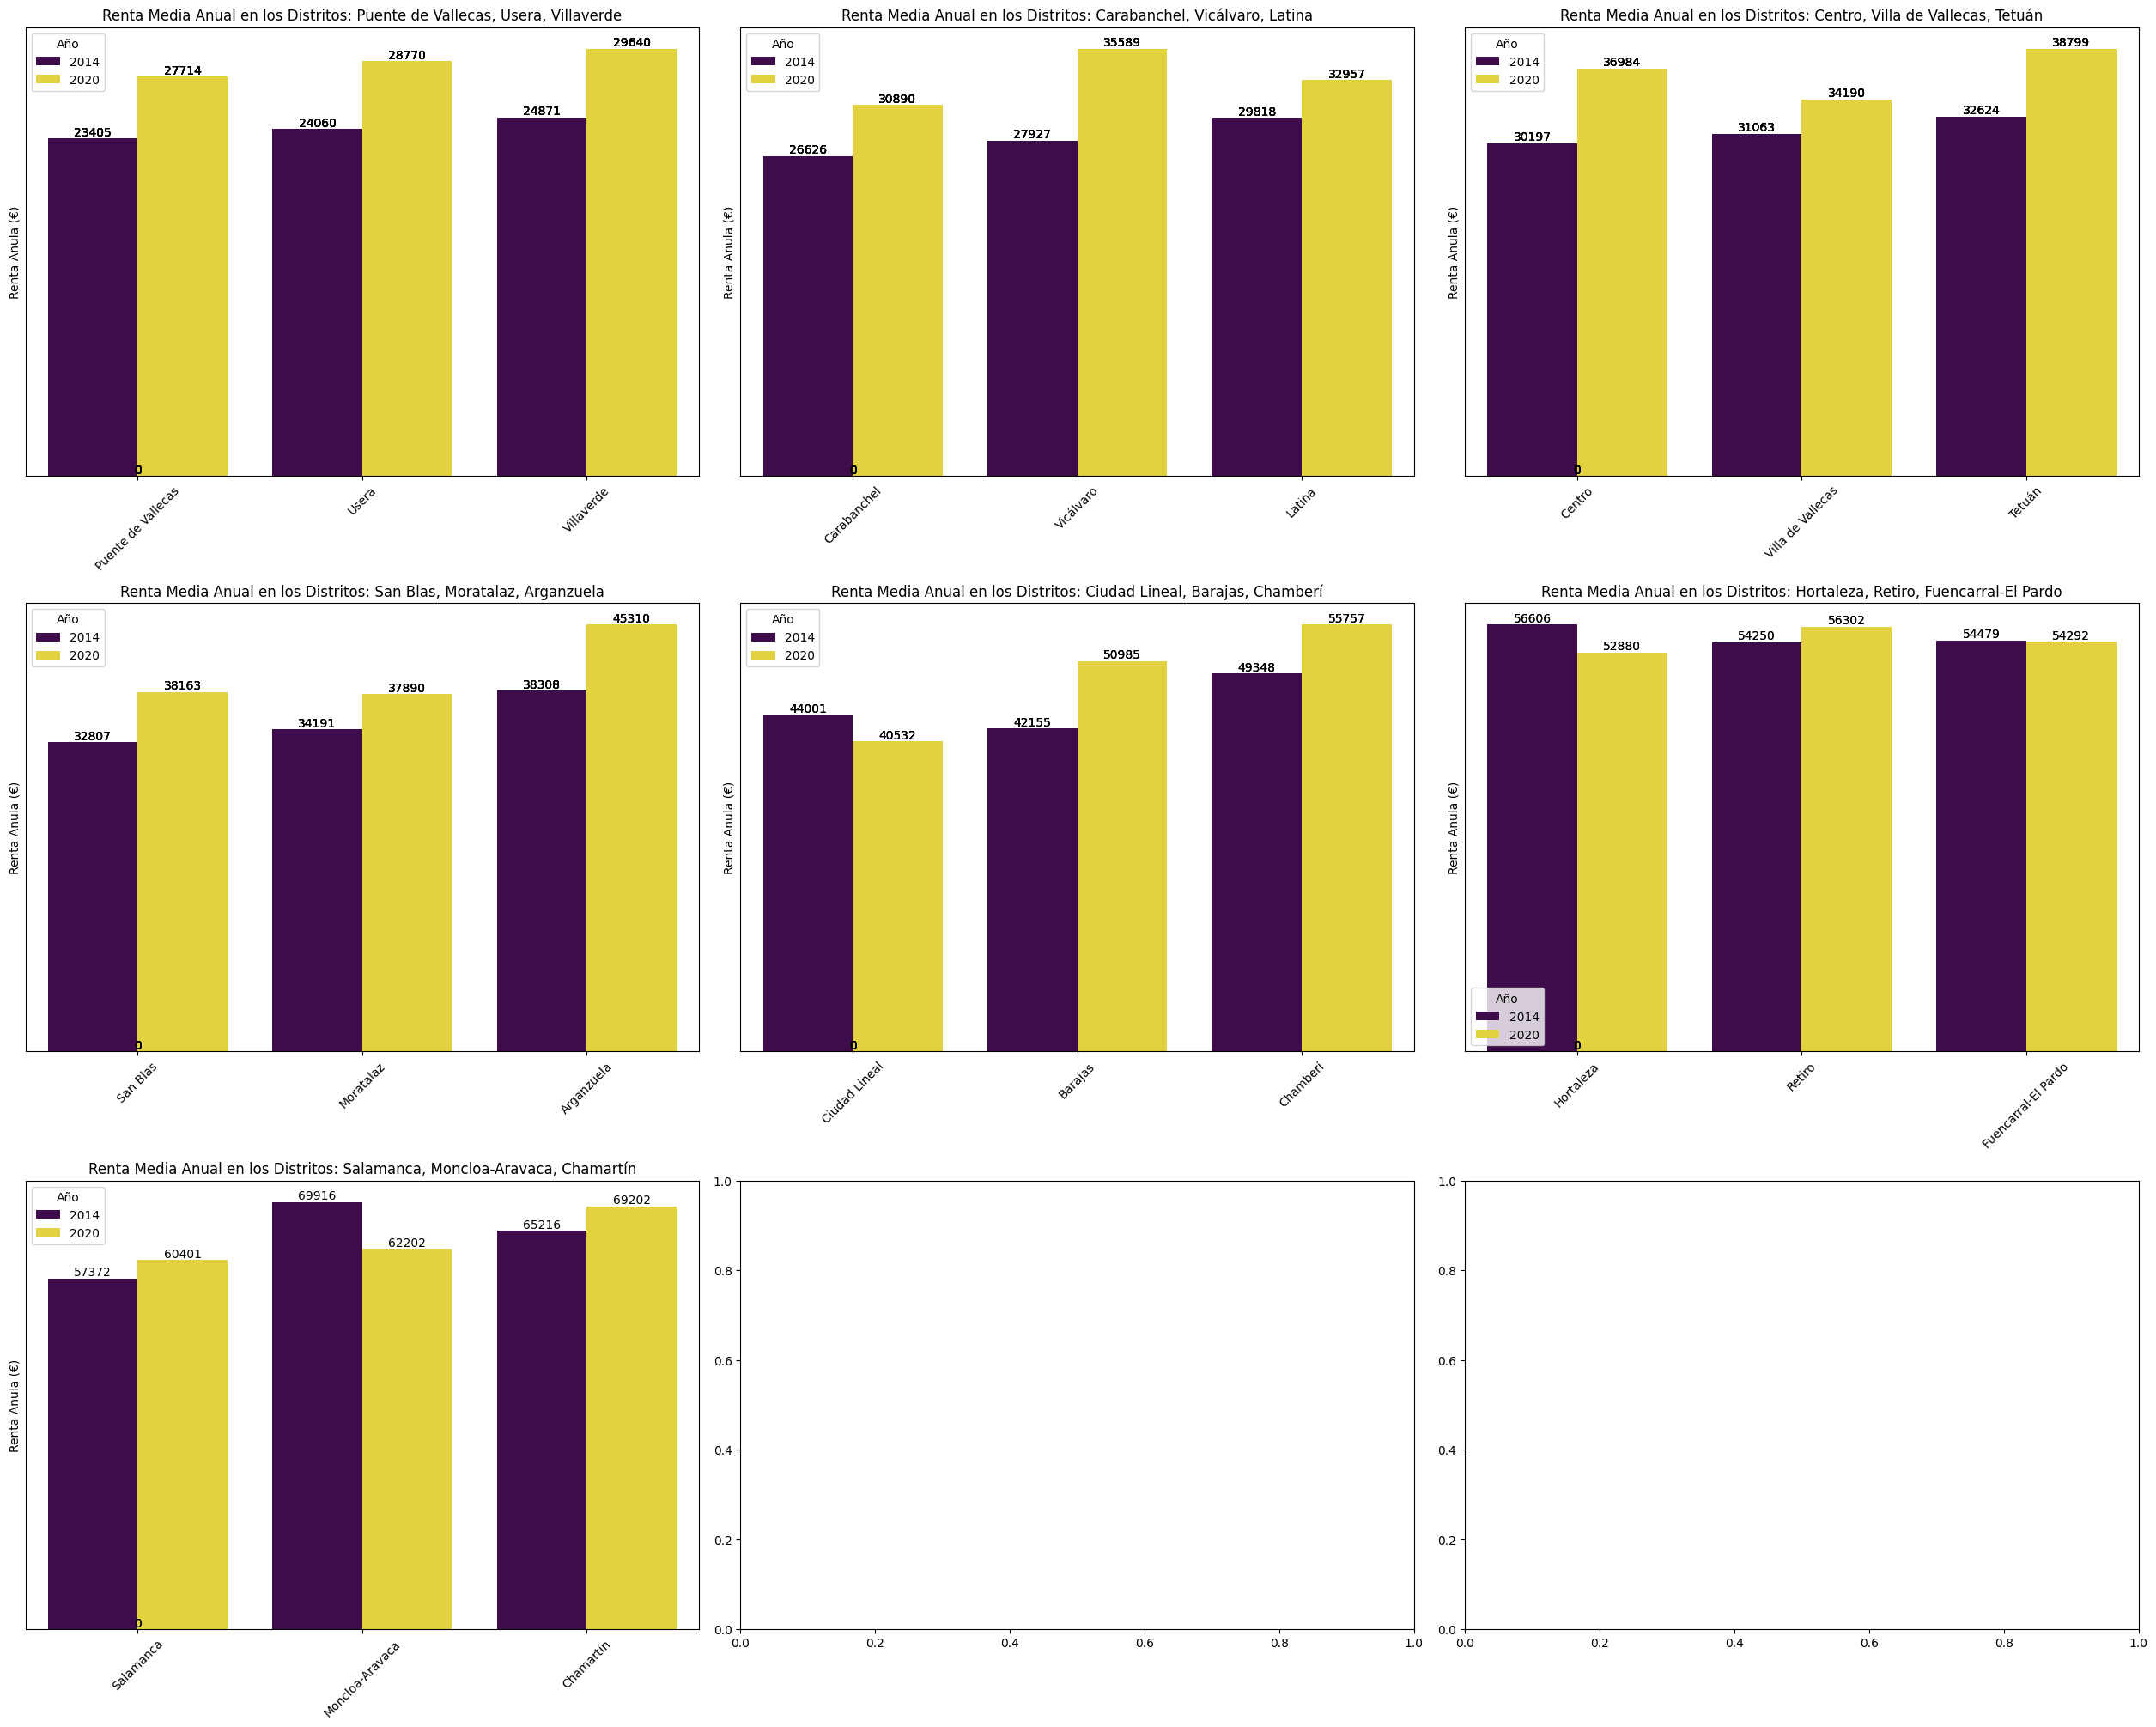

In [76]:
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(25, 20), constrained_layout=True)

#  Filtrado
df_sort = df_union.sort_values(by="Renta") 
distritos = df_sort['Distrito'].unique() 

distritos_por_grafica = 3

for i in range(0, len(distritos), distritos_por_grafica):
    row = (i // distritos_por_grafica) // cols
    col = (i // distritos_por_grafica) % cols

    subset_distritos = distritos[i:i + distritos_por_grafica]

    subset = df_sort[df_sort['Distrito'].isin(subset_distritos)]

    sns.barplot(
        data=subset, 
        x = "Distrito",
        y='Renta', 
        hue='Año', 
        ax=axs[row, col],
        palette='viridis'
    )

    axs[row, col].set_title(f'Renta Media Anual en los Distritos: {", ".join(subset_distritos)}', fontsize=12)
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel("Renta Anula (€)")
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].tick_params(axis="y", left=False, labelleft=False)
    axs[row, col].legend(title='Año')

    for ax in axs.flat:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height, f'{height:.0f}', 
                    ha='center', va='bottom')

plt.show()

*En la gran mayoría de los distritos ha habido una mejoría en su renta anual del 2014 al 2020, salvo alguna excepción cono en Moncloa-Aravaca, Hortaleza y Ciudad Lineal*

*Entonces, ¿cómo será la tasa de idoneidad por cada distrito?¿Qué distrito tendrá un índice de idoneidad elevado?¿Y el más bajo?* 

> Haremos un análisis entre la tasa de idoneidad, niveles, distrito y cuso escolar de los 3 distritos con mayor renta y los 3 distritos con menor renta

In [77]:
#Primero sumo la totalidad de las rentas de ambos años por distrito
renta_total = df_union.groupby('Distrito')['Renta'].sum().reset_index()

In [78]:
# Busco los 3 distritos con mayor renta y los 3 con menor renta
mayor_renta = renta_total.nlargest(3, 'Renta')['Distrito'].values
menor_renta = renta_total.nsmallest(3, 'Renta')['Distrito'].values

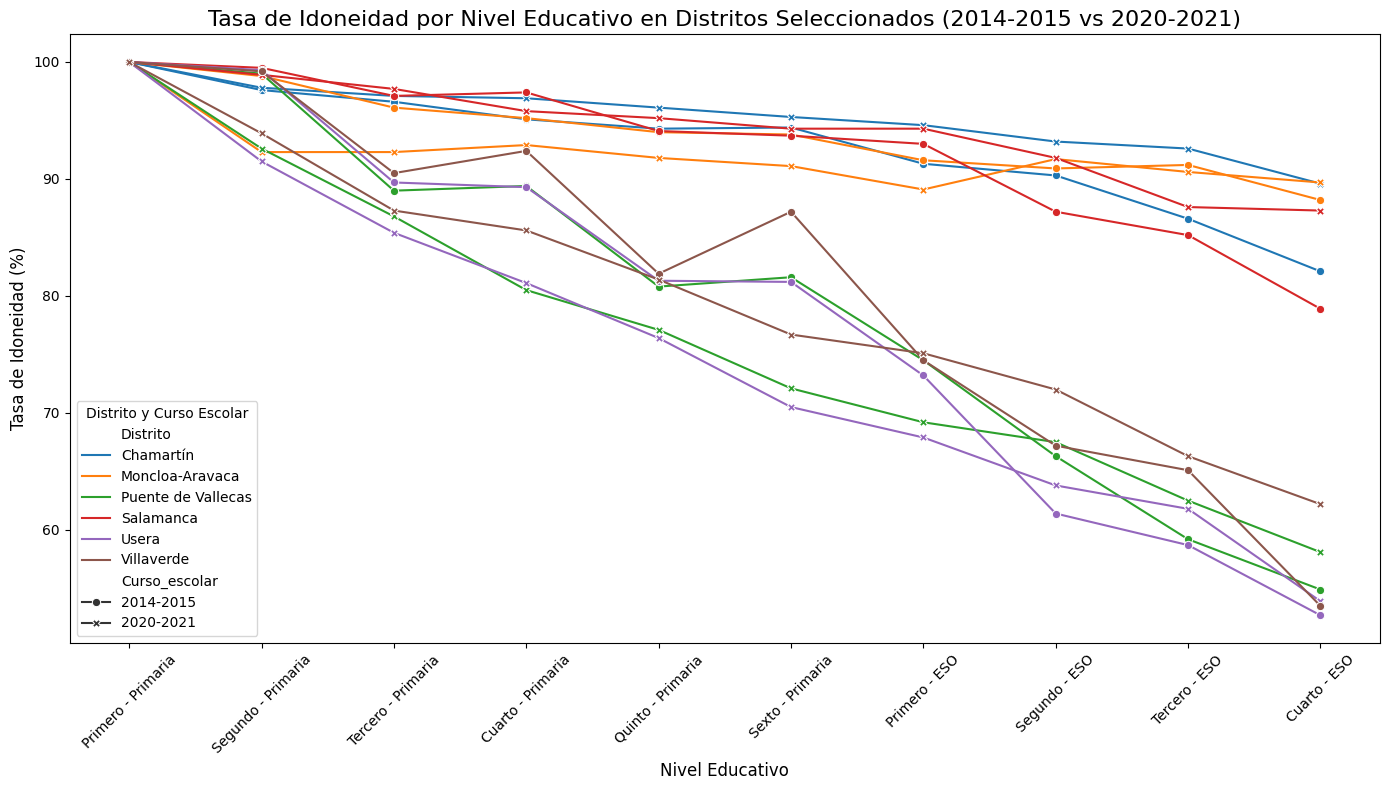

In [79]:
# Filtrar df_estudios para incluir solo los distritos seleccionados
distritos_interes = list(mayor_renta) + list(menor_renta)
df_estudios_filtrado = df_estudios[df_estudios['Distrito'].isin(distritos_interes)]

plt.figure(figsize=(14, 8))

# Graficar las líneas para cada distrito y año
sns.lineplot(
    data=df_estudios_filtrado,
    x='Niveles',
    y='Tasa_idoneidad_%',
    hue='Distrito',
    style='Curso_escolar',
    markers=True,
    dashes=False,
    palette='tab10'
)

# Configuraciones adicionales
plt.title('Tasa de Idoneidad por Nivel Educativo en Distritos Seleccionados (2014-2015 vs 2020-2021)', fontsize=16)
plt.xlabel('Nivel Educativo', fontsize=12)
plt.ylabel('Tasa de Idoneidad (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Distrito y Curso Escolar')
plt.tight_layout()
plt.show()

*Se aprecia como los 3 distritos con mayor renta anual, su tasa de idoneidad permanecen elevadas por lo tanto, sus líneas no descienden mucho. Sin embargo, los 3 distritos con menor renta, sus lineas descienden queriendo decir que su tasa de idoneidad baja. Además, se observa que la línea que representa al año 2020-2021, está por encima de la línea del curso 2014-2015 ya que observamos que en ese año, los ingresos fueron más elevados* 

Para poder verificar más a fondo esta relación entre la tasa de idoneidad y la renta anual de cada distrito, realizaremos un test de correlación.

##### 4.  TEST DE CORRELACIÓN


In [80]:
correlacion = df_union[['Renta', 'Tasa_idoneidad_%']].corr(method='pearson').iloc[0, 1]


In [81]:
correlacion

0.4437631471383507

*Este resultado, significa que tiene una correlación positiva, es decir, a medida que aumenta la renta anual media, también tiende a aumentar la tasa de idoneidad. Esto sugiere que los distritos con mayor renta media anual suelen tener tasas de idoneidad más altas.*

*Sin embargo, la correlación no es tan fuerte como para afirmar que la renta es el único o principal factor determinante de la tasa de idoneidad. Puede influir otros factores como la calidad de la educación, infraestructuras, políticas educativas... Aunque es lo suficientemente significativa como para indicar una relación directa entre ambas variables.*

**Por lo tanto, afirmamos nuestra hipótesis, es decir, las familais que tienen mayor nivel económico tienen una mayor progresión en sus estudios**